# LISA Degradation Analysis: Impact of Detector Performance on EMRI/IMRI Science

This notebook analyzes how detector sensitivity degradation affects the scientific capabilities of LISA (Laser Interferometer Space Antenna) for observing Extreme Mass Ratio Inspirals (EMRIs) and Intermediate Mass Ratio Inspirals (IMRIs). 

## Overview

EMRIs and IMRIs occur when a stellar-mass compact object (typically 1-100 solar masses) spirals into a supermassive black hole (10⁴-10⁷ solar masses).

This analysis explores three key questions:
1. **Signal-to-Noise Ratio (SNR)**: How does detector degradation reduce the SNR for sources at various redshifts and mass configurations?
2. **Redshift Reach**: How does degradation limit the maximum distance (redshift) at which EMRIs can be detected above a given SNR threshold?
3. **Parameter Estimation Precision**: How does degradation degrade our ability to measure source parameters (masses, spin, eccentricity, distance)?

## Degradation Model

We model detector degradation as a multiplicative factor *d* applied to the noise spectral density:
- Sₙ(f) → d × Sₙ(f)
- This scales the SNR as: SNR_degraded = SNR_original / √d
- Parameter estimation uncertainties scale as: σ_degraded = σ_original × √d

## Data Sources

The notebook uses:
- **SNR data**: Pre-computed SNR values for EMRI sources across parameter space (mass, spin, eccentricity, mission lifetime)
- **Inference data**: Fisher matrix parameter estimation results for circular and eccentric orbits
- **Comparison data**: SDSS quasar catalog, LVK gravitational wave detections, QPE sources, and AGN observations

In [1]:
# Standard libraries for data handling and analysis
import h5py  # For reading HDF5 data files
import numpy as np  # Numerical operations
import glob  # File pattern matching
import json  # JSON file handling
import os
import matplotlib.pyplot as plt  # Plotting
import matplotlib.cm as cm  # Colormaps
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d  # 1D interpolation
from math import log10, floor  # Mathematical functions

# Interactive widgets for parameter exploration
from ipywidgets import Dropdown, FloatSlider, HBox, Output, interact, widgets
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Custom cosmology utilities (from common.py)
from common import CosmoInt  # Cosmology interpolator for distance-redshift conversions
from common import ref_cosmo  # Reference cosmology (FlatLambdaCDM)

# Configure matplotlib for publication-quality plots
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (16, 9)  # Double-column paper width

# Cosmology: Redshift to Luminosity Distance

This section verifies the cosmology model by plotting the relationship between redshift *z* and luminosity distance *Dₗ*. The `CosmoInt` utility provides fast interpolated conversions between these quantities using the Planck 2018 cosmological parameters.

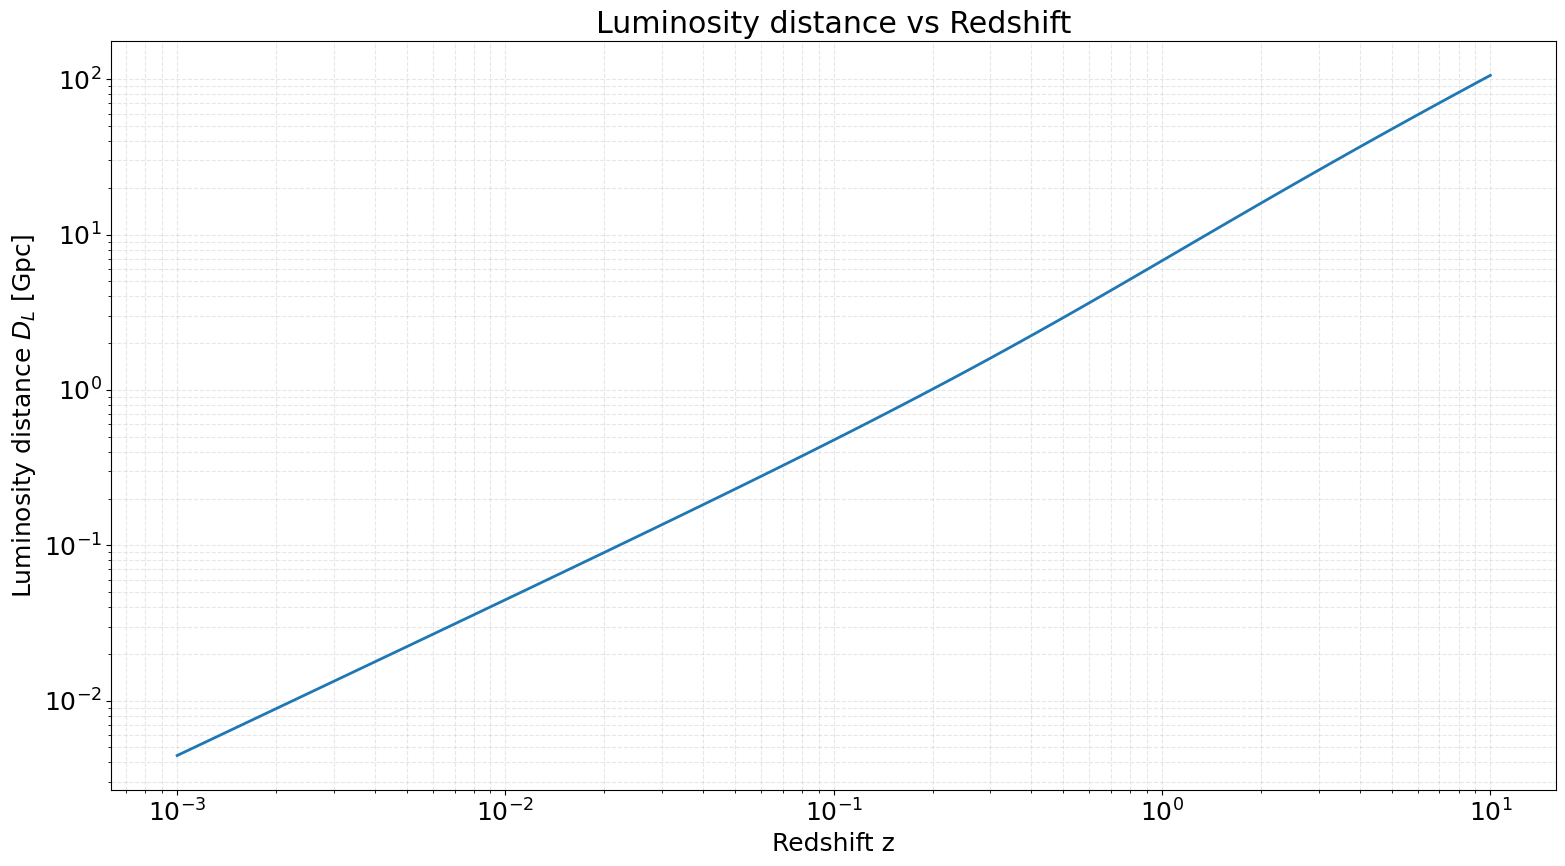

Distance at z = 0.01: 0.0446 Gpc


In [2]:
# Create redshift array spanning z = 0.001 to z = 10
z_vec = np.logspace(-3, 1, 100)

# Convert to luminosity distances (in Gpc)
d_vec = CosmoInt.get_luminosity_distance(z_vec)

# Plot redshift-distance relation
plt.figure()
plt.plot(z_vec, d_vec, linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Redshift z')
plt.ylabel(r'Luminosity distance $D_L$ [Gpc]')
plt.title('Luminosity distance vs Redshift')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Example: Get distance at z = 0.01
print(f"Distance at z = 0.01: {CosmoInt.get_luminosity_distance(1e-2):.4f} Gpc")

# SDSS Quasar Data: Black Hole Mass Measurements

## Error Propagation

The SDSS DR16Q catalog provides black hole masses as log₁₀(M/M☉) with uncertainties. The relationship between relative and logarithmic errors is:

$$
\ln (10) \sigma[\log_{10}M] = \sigma[\ln (M)] = \sigma[M] / M
$$

This conversion is used to compute fractional mass uncertainties for comparison with EMRI parameter estimation precision.

In [3]:
# import pandas as pd
# data_sdss = pd.read_csv("dr16_signorini.txt", delim_whitespace=True, comment='#', 
#                         names=['SDSS_NAME', 'RA', 'DEC', 'Z_DR16Q', 'LOGLBOL', 'LOGLBOL_ERR',
#                                'LOGMBH_HB', 'LOGMBH_HB_ERR', 'LOGMBH_MGII', 'LOGMBH_MGII_ERR',
#                                'LOGMBH_CIV', 'LOGMBH_CIV_ERR', 'LOGMBH', 'LOGMBH_ERR',
#                                'LOGLEDD_RATIO', 'LOGLEDD_RATIO_ERR'])

# mask = (data_sdss['Z_DR16Q'] > 0 ) & (data_sdss['LOGMBH'] > 0)
# # create names, ra, dec, redshift, log10mbh, log10mbh_err arrays
# names = data_sdss['SDSS_NAME'][mask].values
# ra = data_sdss['RA'][mask].values
# dec = data_sdss['DEC'][mask].values
# redshift = data_sdss['Z_DR16Q'][mask].values
# log10mbh = data_sdss['LOGMBH'][mask].values
# log10mbh_err = data_sdss['LOGMBH_ERR'][mask].values
# relative_error_mass = data_sdss['LOGMBH_ERR'] * np.log(10)
# flag_measurement = np.where(
#     data_sdss.loc[mask, 'LOGMBH_CIV'] > 0.0, 'CIV',
#     np.where(
#         data_sdss.loc[mask, 'LOGMBH_HB'] > 0.0, 'HB',
#         np.where(data_sdss.loc[mask, 'LOGMBH_MGII'] > 0.0, 'MGII', 'NA')
#     )
# )
# # save to hdf5 file
# with h5py.File('sdss_dr16q_quasars.h5', 'w') as f:
#     f.create_dataset('names', data=names.astype('S'))
#     f.create_dataset('ra', data=ra)
#     f.create_dataset('dec', data=dec)
#     f.create_dataset('redshift', data=redshift)
#     f.create_dataset('log10massbh', data=log10mbh)
#     f.create_dataset('log10massbh_err', data=log10mbh_err)
#     f.create_dataset('flag', data=flag_measurement.astype('S'))
    
#     # Add descriptive attributes
#     f.attrs['description'] = 'SDSS DR16Q Quasar Sample with Black Hole Mass Measurements'
#     f.attrs['source'] = 'Sloan Digital Sky Survey Data Release 16 (2018)'
#     f.attrs['reference'] = 'https://www.sdss4.org/dr16/'
#     f.attrs['sample_size'] = len(names)
#     f.attrs['notes'] = 'Color-selected quasars. Spectroscopic redshifts. SMBH masses measured via Hbeta (z<2) and MgII (z>=2). Systematic offset present between Hbeta and MgII measurements.'

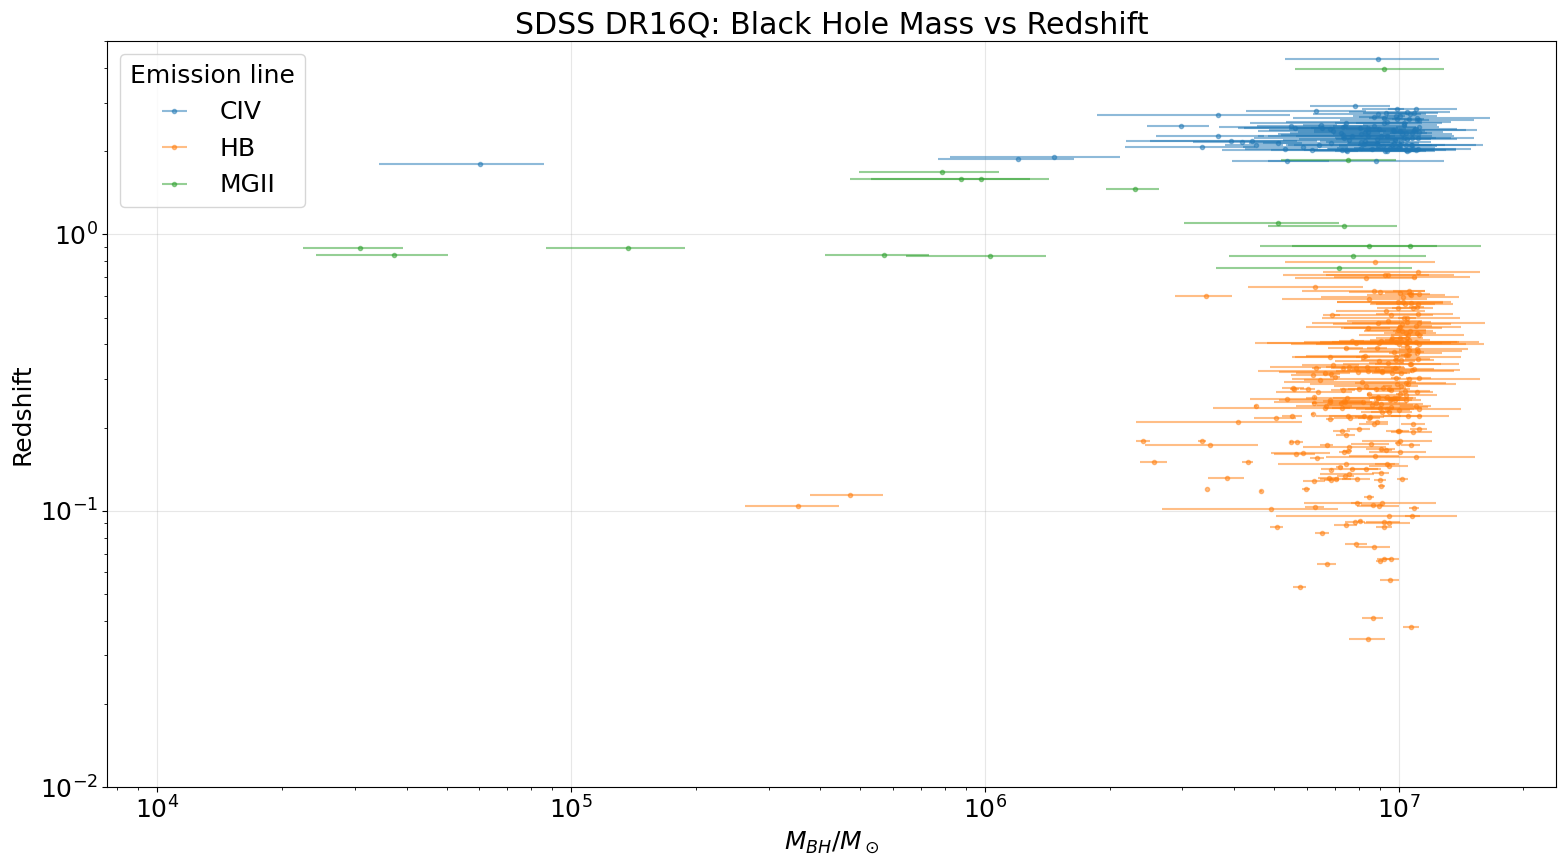

In [4]:
# Load SDSS DR16Q quasar data from HDF5 file
with h5py.File('sdss_dr16q_quasars.h5', 'r') as f:
    redshift_sdss = f['redshift'][:]
    log10massbh_sdss = f['log10massbh'][:]
    log10massbh_err_sdss = f['log10massbh_err'][:]
    
    # Convert logarithmic error to relative error: σ(M)/M = ln(10) × σ(log₁₀M)
    relative_error_mass = log10massbh_err_sdss * np.log(10)
    
    # Quality cut: Keep only sources with M < 10^7.05 M☉ and relative error < 50%
    mask = (log10massbh_sdss < 7.05) & (relative_error_mass < 0.5)
    redshift_sdss = redshift_sdss[mask]
    log10massbh_sdss = log10massbh_sdss[mask]
    log10massbh_err_sdss = log10massbh_err_sdss[mask]
    
    # Convert to linear mass and absolute error
    massbh_sdss = 10**log10massbh_sdss
    error_massbh_sdss = massbh_sdss * relative_error_mass[mask]
    
    # Flag indicating which emission line was used for mass measurement
    flag_measurement = f['flag'][:][mask]

# Plot mass vs redshift, color-coded by measurement method
plt.figure()
for el in np.unique(flag_measurement):
    flag_mask = flag_measurement == el
    plt.errorbar(massbh_sdss[flag_mask], redshift_sdss[flag_mask], 
                 xerr=error_massbh_sdss[flag_mask], fmt='.', alpha=0.5, 
                 label=el.decode('utf-8'))  # CIV, HB (Hβ), or MGII (MgII)

plt.ylabel('Redshift')
plt.xlabel(r'$M_{BH}/M_\odot$')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Emission line')
plt.ylim(0.01, 5)
plt.title('SDSS DR16Q: Black Hole Mass vs Redshift')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Multiwavelength Observations: Context for LISA Science

This section compares the EMRI parameter space accessible to LISA with existing observations from:
- **Dynamical measurements**: Direct mass measurements from stellar/gas kinematics (green circles)
- **LVK detections**: LIGO-Virgo-KAGRA gravitational wave observations (blue points)
- **QPE/QPO sources**: Quasi-periodic eruptions and oscillations in AGN (purple diamonds)
- **AGN observations**: Active galactic nuclei with X-ray reverberation mapping (red X's)
- **SDSS quasars**: Spectroscopic black hole mass estimates (gray points)

LISA will bridge the gap between electromagnetic and ground-based GW observations, providing precision measurements in an unexplored parameter space.

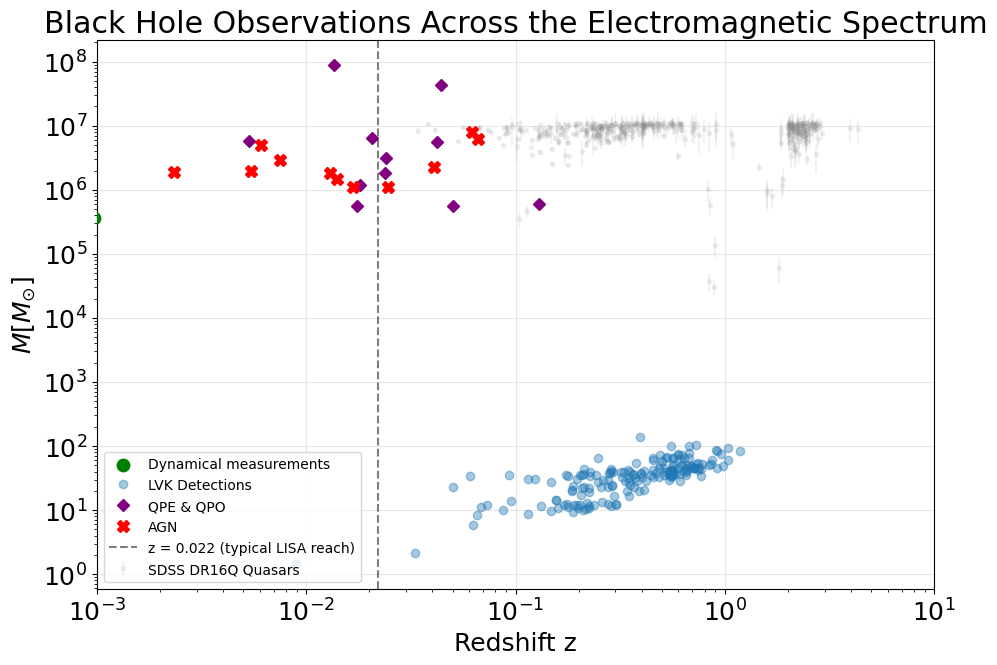

In [5]:
# Dynamical mass measurements from nearby galaxies (from Gebhardt+ 2019)
# These are the most precise black hole mass measurements available
green_points = {  # distance in Mpc, mass in solar masses (https://arxiv.org/pdf/1911.09678 Figure 2)
    'M32': (0.785, 2.5e6),      # Nguyen+2019
    'N5102': (3.4, 9e5),        # Nguyen+2019
    'N5206': (3.8, 5.4e5),      # Nguyen+2019
    'N4395': (4.3, 3.6e5),      # den Brok+2015
    'N205': (0.824, 2e4),       # Nguyen+2019
}

fig, ax = plt.subplots(figsize=(10, 7))

# Convert distances to redshifts for dynamical measurements
z_dyn, m_dyn = np.asarray([(CosmoInt.get_redshift(d/1e3), m) for name, (d, m) in green_points.items()]).T

# Load LIGO-Virgo-KAGRA gravitational wave detections
with open('lvk_gw_events.json', 'r') as f:
    data_lvk = json.load(f)

# Quasi-Periodic Eruption (QPE) sources (from https://arxiv.org/pdf/2404.00941)
masses_qpe = np.asarray([1.2, 0.55, 0.55, 3.1, 42.5, 1.8, 5.5, 0.595, 6.55, 88.0, 5.8]) * 1e6
z_qpe = np.asarray([0.0181, 0.0505, 0.0175, 0.024, 0.044, 0.0237, 0.042, 0.13, 0.0206, 0.0136, 0.0053])
d_qpe = CosmoInt.get_luminosity_distance(z_qpe)

# Active Galactic Nuclei (AGN) with X-ray reverberation mapping (from arXiv:2501.03252v2, Table EM_measure)
smbh_data = [
    {"name": "UGC 01032", "mass": 1.1, "redshift": 0.01678, "alternate_names": "Mrk 359"},
    {"name": "UGC 12163", "mass": 1.1, "redshift": 0.02468, "alternate_names": "Ark 564"},
    {"name": "Swift J2127.4+5654", "mass": 1.5, "redshift": 0.01400, "alternate_names": ""},
    {"name": "NGC 4253", "mass": 1.8, "redshift": 0.01293, "alternate_names": "UGC 07344, Mrk 766"},
    {"name": "NGC 4051", "mass": 1.91, "redshift": 0.00234, "alternate_names": "UGC 07030"},
    {"name": "NGC 1365", "mass": 2.0, "redshift": 0.00545, "alternate_names": ""},
    {"name": "1H0707-495", "mass": 2.3, "redshift": 0.04056, "alternate_names": ""},
    {"name": "MCG-6-30-15", "mass": 2.9, "redshift": 0.00749, "alternate_names": ""},
    {"name": "NGC 5506", "mass": 5.0, "redshift": 0.00608, "alternate_names": "Mrk 1376"},
    {"name": "IRAS13224-3809", "mass": 6.3, "redshift": 0.06579, "alternate_names": ""},
    {"name": "Ton S180", "mass": 8.1, "redshift": 0.06198, "alternate_names": ""},
]
smbh_masses = np.array([item['mass'] for item in smbh_data]) * 1e6
smbh_redshifts = np.array([item['redshift'] for item in smbh_data])
smbh_distances = CosmoInt.get_luminosity_distance(smbh_redshifts)

# Plot all observational datasets
ax.scatter(z_dyn, m_dyn, marker='o', s=80, color='green', label='Dynamical measurements', zorder=5)
ax.plot(data_lvk['redshift'], data_lvk['primary_mass'], 'o', alpha=0.4, label='LVK Detections')
ax.plot(z_qpe, masses_qpe, 'D', color='purple', markersize=6, label='QPE & QPO')
ax.plot(smbh_redshifts, smbh_masses, 'X', color='red', markersize=8, label='AGN', zorder=4)
plt.errorbar(redshift_sdss, massbh_sdss, yerr=error_massbh_sdss, 
             fmt='.', alpha=0.1, color='grey', label='SDSS DR16Q Quasars', zorder=0)

# Set scales and limits
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 10)

# Reference line at z = 0.022 (approximate LISA horizon for typical EMRIs)
ax.axvline(0.022, color='black', linestyle='--', alpha=0.5, linewidth=1.5, label='z = 0.022 (typical LISA reach)')

# Labels and legend
ax.set_xlabel('Redshift z')
ax.set_ylabel(r'$M [M_{\odot}]$')
ax.legend(loc='lower left', fontsize=10)
ax.set_title('Black Hole Observations Across the Electromagnetic Spectrum')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Load and Organize Detection Data from All Sources

In [6]:
# Load all detection.h5 files from snr_* directories
# Each file contains SNR data for one EMRI source configuration across multiple redshifts and sky realizations
detection_files = sorted(glob.glob('snr_*/detection.h5'))
print(f"Found {len(detection_files)} detection.h5 files")

# Dictionary to store data indexed by source_id
# source_metadata: stores scalar parameters (m1, m2, a, p0, e0, Tpl) for each source
# source_snr_data: stores SNR arrays as function of redshift (10 redshifts × 100 sky realizations)
source_metadata = {}
source_snr_data = {}

for idx, det_file in enumerate(detection_files):
    # Extract source ID from directory name (e.g., 'snr_42/detection.h5' -> source_id=42)
    source_id = int(det_file.split('_')[1].split('/')[0])
    print(f"Loading source {idx+1}/{len(detection_files)}: {det_file} (ID={source_id})")
    
    with h5py.File(det_file, 'r') as f:
        # Extract scalar metadata for this source configuration
        source_metadata[source_id] = {
            'm1': float(np.round(f['m1'][()], decimals=5)),    # Primary mass [M☉]
            'm2': float(np.round(f['m2'][()], decimals=5)),    # Secondary mass [M☉]
            'a': float(np.round(f['a'][()], decimals=5)),      # Spin parameter [-1, 1]
            'p0': float(f['p0'][()]),                          # Initial semi-latus rectum [M]
            'e0': float(f['e0'][()]),                          # Initial eccentricity
            'T': float(np.round(f['Tpl'][()], decimals=5)),    # Time to plunge [years]
        }
        
        # Extract SNR data as function of redshift
        # snr shape: (10 redshifts, 100 sky/orientation realizations)
        snr_data = f['snr'][()]       # (10, 100)
        redshifts = f['redshift'][()]  # (10,) - redshift values
        dist = f['dist'][()]           # (10,) - luminosity distances [Gpc]
        
        # Store SNR data indexed by redshift for easy lookup
        source_snr_data[source_id] = {}
        for z_idx, z_val in enumerate(redshifts):
            source_snr_data[source_id][float(z_val)] = snr_data[z_idx, :]  # 100 realizations at this z

print("\nData loading complete!")
print(f"Loaded metadata for {len(source_metadata)} sources")
print(f"Loaded SNR data for {len(source_snr_data)} sources")
print(f"Redshift range: {redshifts.min():.6f} to {redshifts.max():.6f}")
print(f"Luminosity distance range: {dist.min():.4f} to {dist.max():.4f} Gpc")

# Verify cosmology consistency between distance and redshift arrays
print("Cosmology check:", 
    np.isclose(CosmoInt.get_redshift(dist.min()), redshifts.min()), 
    np.isclose(CosmoInt.get_luminosity_distance(redshifts.max()), dist.max()))

Found 58 detection.h5 files
Loading source 1/58: snr_0/detection.h5 (ID=0)
Loading source 2/58: snr_1/detection.h5 (ID=1)
Loading source 3/58: snr_10/detection.h5 (ID=10)
Loading source 4/58: snr_11/detection.h5 (ID=11)
Loading source 5/58: snr_12/detection.h5 (ID=12)
Loading source 6/58: snr_13/detection.h5 (ID=13)
Loading source 7/58: snr_14/detection.h5 (ID=14)
Loading source 8/58: snr_15/detection.h5 (ID=15)
Loading source 9/58: snr_16/detection.h5 (ID=16)
Loading source 10/58: snr_17/detection.h5 (ID=17)
Loading source 11/58: snr_18/detection.h5 (ID=18)
Loading source 12/58: snr_19/detection.h5 (ID=19)
Loading source 13/58: snr_2/detection.h5 (ID=2)
Loading source 14/58: snr_20/detection.h5 (ID=20)
Loading source 15/58: snr_21/detection.h5 (ID=21)
Loading source 16/58: snr_22/detection.h5 (ID=22)
Loading source 17/58: snr_23/detection.h5 (ID=23)
Loading source 18/58: snr_24/detection.h5 (ID=24)
Loading source 19/58: snr_25/detection.h5 (ID=25)
Loading source 20/58: snr_26/detectio

Detection Volume: 73.67 Gpc³ (for SNR threshold = 30)


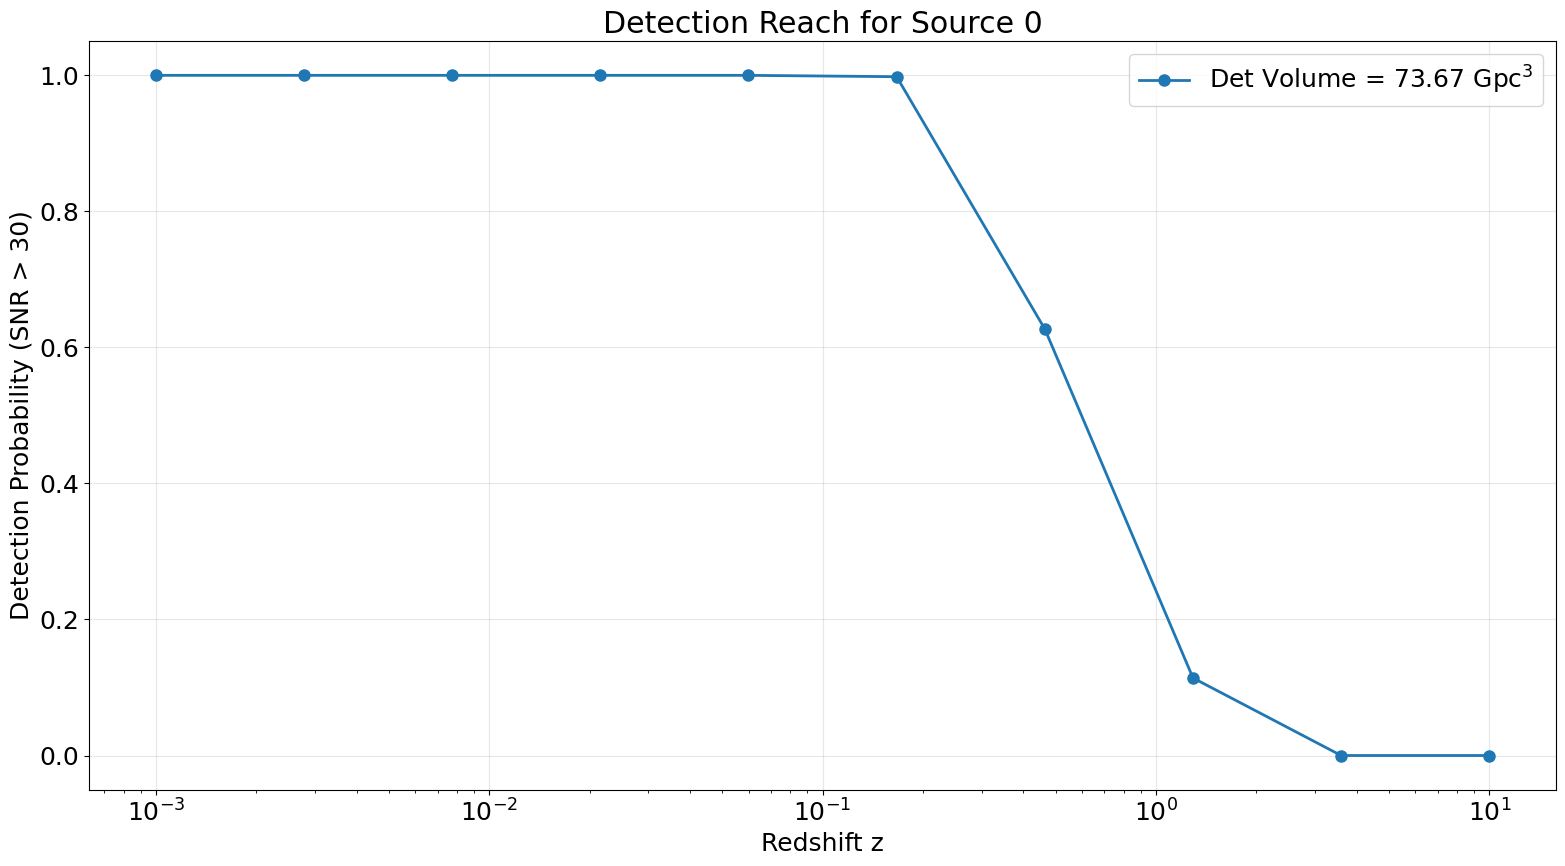

In [7]:
# Example: Compute detection volume for a single source (source_id = 0)
# Detection volume is the cosmological volume within which a source would be detected with SNR > threshold

source_id = 0
plt.figure()

# Extract detection probability as function of redshift (fraction of sky realizations with SNR > 30)
red_, pdet = np.asarray([
    [key, np.sum(np.asarray(item) > 30.) / len(item)] 
    for key, item in source_snr_data[source_id].items()
]).T

# Interpolate detection probability vs log(redshift) for smooth integration
pdet_interp = interp1d(np.log10(red_), pdet, kind='linear', 
                       bounds_error=False, fill_value=(1.0, 0.0))  # p=1 at z→0, p=0 at z→∞

# Compute comoving volume element dV/dz
z_ = np.logspace(-3, 1, 1000)
Vc = np.asarray(ref_cosmo.comoving_volume(z_)) * (1e-3)**3  # Convert Mpc³ to Gpc³
dVc = np.gradient(Vc, z_)  # dV/dz

# Integrate detection probability over volume, accounting for time dilation factor (1+z)
# V_det = ∫ p_det(z) × dV/dz × dz/(1+z)
det_Volume = np.trapezoid(pdet_interp(np.log10(z_)) * dVc / (1+z_), z_)
print(f"Detection Volume: {det_Volume:.2f} Gpc³ (for SNR threshold = 30)")

# Plot detection probability vs redshift
plt.semilogx(red_, pdet, 'o-', markersize=8, linewidth=2,
            label=f'Det Volume = {det_Volume:.2f} Gpc$^3$')
plt.xlabel("Redshift z")
plt.ylabel("Detection Probability (SNR > 30)")
plt.title(f"Detection Reach for Source {source_id}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Extract unique parameter values across all sources for dropdown menus
# This allows filtering and selecting specific source configurations in the interactive plots

Tpl_values = sorted(set(source_metadata[src]['T'] for src in source_metadata))  # Mission lifetime (plunge time)
a_values = sorted(set(source_metadata[src]['a'] for src in source_metadata))     # Spin parameter
m1_values = sorted(set(source_metadata[src]['m1'] for src in source_metadata))   # Primary mass
m2_values = sorted(set(source_metadata[src]['m2'] for src in source_metadata))   # Secondary mass

# Collect all unique redshifts across all sources
all_redshifts = set()
for src_id in source_snr_data:
    all_redshifts.update(source_snr_data[src_id].keys())
all_redshifts = sorted(all_redshifts)

# Display parameter space coverage
print(f"Parameter space coverage:")
print(f"  Tpl values (mission lifetime): {Tpl_values} years")
print(f"  Spin (a) values: {a_values}")
print(f"  Primary mass (m1) values: {len(m1_values)} unique values")
print(f"  Secondary mass (m2) values: {len(m2_values)} unique values")
print(f"  Number of unique redshifts: {len(all_redshifts)}")
print(f"  Redshift range: z = {min(all_redshifts):.6f} to {max(all_redshifts):.6f}")

Parameter space coverage:
  Tpl values (mission lifetime): [0.25, 1.5, 4.5] years
  Spin (a) values: [-0.99, 0.99]
  Primary mass (m1) values: 4 unique values
  Secondary mass (m2) values: 7 unique values
  Number of unique redshifts: 10
  Redshift range: z = 0.001000 to 10.000000


## Interactive Degradation Analysis: SNR and Redshift Reach

This section provides interactive visualizations showing how detector degradation affects EMRI detectability:

**Top Panel**: SNR vs primary mass m₁ at fixed redshift
- Solid circles: Current LISA sensitivity
- Dashed squares: Degraded sensitivity
- Arrows show the SNR loss due to degradation

**Bottom Panel**: Maximum detection redshift vs m₁ at fixed SNR threshold
- Shows how far we can detect sources with different configurations
- Arrows indicate loss of redshift reach due to degradation

**Degradation Model**: The degradation factor *d* scales the noise spectral density as:
$$S_n(f) \rightarrow d \cdot S_n(f)$$

This translates to an SNR scaling of:
$$\mathrm{SNR}_{\mathrm{degraded}} = \frac{\mathrm{SNR}_{\mathrm{original}}}{\sqrt{d}}$$

Use the interactive controls to explore different source configurations, spins, mission lifetimes, and degradation levels.

In [9]:
# Create interactive widgets for degradation analysis
# These widgets allow users to explore how detector degradation affects SNR and redshift reach

# Dropdown for mission lifetime (time to plunge)
tpl_dropdown_deg = Dropdown(
    options=[(f'Tpl = {t:.2f}', t) for t in Tpl_values],
    description='Tpl:',
    value=Tpl_values[0]
)

# Dropdown for spin parameter (a = -1 retrograde, a = +1 prograde)
spin_dropdown_deg = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values],
    description='Spin (a):',
    value=a_values[-1]  # Default to maximum spin (prograde)
)

# Dropdown for redshift (source distance)
redshift_dropdown_deg = Dropdown(
    options=[(f'z = {z:.6f}', z) for z in all_redshifts],
    description='Redshift:',
    value=all_redshifts[3]
)

# Slider for SNR detection threshold
snr_threshold_slider = widgets.FloatSlider(
    value=30,
    min=5,
    max=100,
    step=5,
    description='SNR threshold:',
    continuous_update=True
)

# Slider for degradation factor d (applied as Sn → d × Sn, so SNR → SNR/√d)
degradation_slider = widgets.FloatSlider(
    value=1.0,
    min=1.0,
    max=3.0,
    step=0.25,
    description='Degradation (d):',
    continuous_update=True
)

# Dropdown to filter by secondary mass
m2_filter_dropdown = Dropdown(
    options=[('All', 'all')] + [(f'm2 = {m2:.0f}', m2) for m2 in sorted(m2_values)],
    description='Secondary mass:',
    value='all'
)

# Output widget for displaying interactive plots
output_deg_plot = Output()

# Configuration for saving figures
savefig_name = 'snr_redshift_vs_m1.png'
save_figure = False  # Set to True to save figures to disk

In [10]:
# Statistical estimator for SNR and precision (can be np.median or np.mean)
# Median is more robust to outliers in sky-averaged quantities
estimator = np.median

In [11]:

def plot_degradation_effect(tpl_val, spin_a, z_val, snr_threshold, degradation, m2_filter):
    """
    Plot showing degradation effect on SNR and redshift.
    Top: SNR vs m1 with arrows showing degradation impact
    Bottom: Redshift vs m1 with arrows showing degradation impact
    """
    tolerance = 1e-6
    matching_sources = []
    
    # Filter sources by Tpl and spin
    for src_idx in sorted(source_metadata.keys()):
        src_a = source_metadata[src_idx]['a']
        src_tpl = source_metadata[src_idx]['T']
        
        if abs(src_a - spin_a) < tolerance and abs(src_tpl - tpl_val) < tolerance:
            matching_sources.append(src_idx)
    
    if not matching_sources:
        with output_deg_plot:
            output_deg_plot.clear_output(wait=True)
            print(f"No sources found for Tpl={tpl_val:.2f}, a={spin_a:.2f}")
        return
    
    # Extract SNR data for specified redshift
    snr_data = {}
    for src_idx in matching_sources:
        m1 = source_metadata[src_idx]['m1']
        m2 = source_metadata[src_idx]['m2']
        
        if z_val not in source_snr_data[src_idx]:
            continue
            
        snr_array = source_snr_data[src_idx][z_val]  # Shape: (100,)
        snr_median = estimator(snr_array)
        
        if m2 not in snr_data:
            snr_data[m2] = {'m1': [], 'snr_orig': []}
        snr_data[m2]['m1'].append(m1)
        snr_data[m2]['snr_orig'].append(snr_median)
    
    # Extract redshift reach data
    z_data = {}
    for src_idx in matching_sources:
        m1 = source_metadata[src_idx]['m1']
        m2 = source_metadata[src_idx]['m2']
        
        # Get SNR vs redshift
        z_snr_dict = source_snr_data[src_idx]
        z_vals_list = sorted(z_snr_dict.keys())
        snr_median_per_z = []
        
        for z in z_vals_list:
            snr_array = z_snr_dict[z]
            snr_median_per_z.append(np.median(snr_array))
        
        snr_median_per_z = np.array(snr_median_per_z)
        z_vals_array = np.array(z_vals_list)
        
        if snr_threshold > np.max(snr_median_per_z):
            continue
        
        try:
            # Original redshift at SNR threshold
            interp_func = interp1d(snr_median_per_z, z_vals_array, kind='linear',
                                   bounds_error=False, fill_value='extrapolate')
            z_at_snr = interp_func(snr_threshold)
            
            # Degraded SNR values
            snr_median_per_z_deg = snr_median_per_z / np.sqrt(degradation)
            interp_func_deg = interp1d(snr_median_per_z_deg, z_vals_array, kind='linear',
                                       bounds_error=False, fill_value='extrapolate')
            z_at_snr_deg = interp_func_deg(snr_threshold)
        except:
            continue
        
        if m2 not in z_data:
            z_data[m2] = {'m1': [], 'z_orig': [], 'z_deg': []}
        z_data[m2]['m1'].append(m1)
        z_data[m2]['z_orig'].append(z_at_snr)
        z_data[m2]['z_deg'].append(z_at_snr_deg)
    
    # Create figure with two subplots
    with output_deg_plot:
        output_deg_plot.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 14))
        
        colors = plt.cm.tab20(np.linspace(0, 1, max(len(snr_data), len(z_data)) or 1))
        
        # TOP PLOT: SNR vs m1 with degradation arrows
        for idx, m2 in enumerate(sorted(snr_data.keys())):
            # Filter by m2 if user selected specific value
            if m2_filter != 'all' and m2 != m2_filter:
                continue
            
            m1_vals = np.array(snr_data[m2]['m1'])
            snr_orig = np.array(snr_data[m2]['snr_orig'])
            snr_deg = snr_orig / np.sqrt(degradation)
            
            sort_idx = np.argsort(m1_vals)
            m1_sorted = m1_vals[sort_idx]
            snr_orig_sorted = snr_orig[sort_idx]
            snr_deg_sorted = snr_deg[sort_idx]
            
            # Plot original and degraded SNR
            ax1.plot(m1_sorted, snr_orig_sorted, 'o-', color=colors[idx],
                    markersize=7, linewidth=1.5, label=f'{m2:.0f}', alpha=0.7)
            ax1.plot(m1_sorted, snr_deg_sorted, 's--', color=colors[idx],
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw downward arrows showing degradation
            for i in range(len(m1_sorted)):
                ax1.annotate('', xy=(m1_sorted[i], snr_deg_sorted[i]),
                           xytext=(m1_sorted[i], snr_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=colors[idx],
                                         lw=1.5, alpha=0.6))
        
        # ax1.set_xlabel('Primary Mass m1 ($M_\\odot$)', fontsize=18)
        ax1.set_ylabel(rf'SNR at $z={z_val:.3f}$')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major')
        

        leg1 = ax1.legend(loc='upper left',
                          #bbox_to_anchor=(0.5, 1.0), 
                          ncols=4, frameon=True, title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        
        # Second legend for line styles
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, loc='lower left', frameon=True)
        ax1.add_artist(leg2)
        if m2_filter == 'all':
            ax1.set_ylim(1, 1e5)
        
        # ax1.legend(fontsize=fontsize_legend, loc='upper center', bbox_to_anchor=(1.25, 0.99), ncols=1, frameon=True, title='$m_2 [M_\odot]$')
        # ax1.set_title(f'SNR Degradation | Tpl={tpl_val:.2f}, a={spin_a:.2f}, z={z_val:.6f}\nd={degradation:.1f}', fontsize=18, fontweight='bold')
        # ax1.legend(fontsize=9, loc='upper right')
        
        # BOTTOM PLOT: Redshift vs m1 with degradation arrows
        for idx, m2 in enumerate(sorted(z_data.keys())):
            # Filter by m2 if user selected specific value
            if m2_filter != 'all' and m2 != m2_filter:
                continue
            
            m1_vals = np.array(z_data[m2]['m1'])
            z_orig = np.array(z_data[m2]['z_orig'])
            z_deg = np.array(z_data[m2]['z_deg'])
            
            sort_idx = np.argsort(m1_vals)
            m1_sorted = m1_vals[sort_idx]
            z_orig_sorted = z_orig[sort_idx]
            z_deg_sorted = z_deg[sort_idx]
            
            # Plot original and degraded redshift
            ax2.plot(m1_sorted, z_orig_sorted, 'o-', color=colors[idx],
                    markersize=7, linewidth=1.5, label=f'm2={m2:.0f}', alpha=0.7)
            ax2.plot(m1_sorted, z_deg_sorted, 's--', color=colors[idx],
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw upward arrows
            for i in range(len(m1_sorted)):
                ax2.annotate('', xy=(m1_sorted[i], z_deg_sorted[i]),
                           xytext=(m1_sorted[i], z_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=colors[idx],
                                         lw=1.5, alpha=0.6))
        
        ax2.set_xlabel(r'Primary mass $m_1 [M_\odot]$')
        ax2.set_ylabel(f'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
        
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=f'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax2.legend(handles=legend_elements, loc='lower left', frameon=True)
        ax2.add_artist(leg2)
        
        # ax2.set_title(f'Redshift Loss | SNR threshold={snr_threshold:.1f}, d={degradation:.1f}', fontsize=18, fontweight='bold')
        # ax2.legend(fontsize=9, loc='upper right')
        if m2_filter == 'all':
            ax2.set_ylim(5e-3, None)
        plt.tight_layout()
        plt.show()

<>:173: SyntaxWarning: invalid escape sequence '\m'
<>:173: SyntaxWarning: invalid escape sequence '\m'
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_2360/3570795645.py:173: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel(f'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$')


In [12]:
# Create and display widget
controls_deg = HBox([tpl_dropdown_deg, spin_dropdown_deg, redshift_dropdown_deg, 
                     snr_threshold_slider, degradation_slider, m2_filter_dropdown])
display(controls_deg)
display(output_deg_plot)

# Create interactive plot
_ = interact(plot_degradation_effect, tpl_val=tpl_dropdown_deg,
             spin_a=spin_dropdown_deg, z_val=redshift_dropdown_deg,
             snr_threshold=snr_threshold_slider, degradation=degradation_slider,
             m2_filter=m2_filter_dropdown)

Output()

interactive(children=(Dropdown(description='Tpl:', options=(('Tpl = 0.25', 0.25), ('Tpl = 1.50', 1.5), ('Tpl =…

In [13]:
# Create global m2 colorscheme for consistent coloring across all plots
all_m2_values_global = sorted(m2_values)
m2_colors_global = plt.cm.tab20(np.linspace(0, 1, len(all_m2_values_global)))
m2_to_color_global = {m2: m2_colors_global[idx] for idx, m2 in enumerate(all_m2_values_global)}

# Mission Lifetime Analysis

This section explores how the LISA mission duration (plunge time Tₚₗ) affects detection capabilities. Longer mission lifetimes allow:
- More orbital cycles to be observed, improving SNR
- Better parameter estimation due to longer coherent integration
- Detection of EMRIs with wider initial orbits

The plots show SNR and redshift reach as functions of Tₚₗ for different mass configurations.

In [14]:
# Create dropdowns for Tpl parameter space plot
m1_filtered = [m1 for m1 in sorted(m1_values) if m1 in [1e6, 1e7]]

m1_dropdown_tpl = Dropdown(
    options=[(f'm1 = {m1:.0e}', m1) for m1 in m1_filtered],
    description='Primary mass:',
    value=m1_filtered[1] if m1_filtered else sorted(m1_values)[len(sorted(m1_values))//2]
)

spin_dropdown_tpl = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values],
    description='Spin (a):',
    value=a_values[-1]
)

redshift_dropdown_tpl = Dropdown(
    options=[(f'z = {z:.6f}', z) for z in all_redshifts],
    description='Redshift:',
    value=all_redshifts[3]
)

snr_threshold_slider = widgets.FloatSlider(
    value=30,
    min=5,
    max=100,
    step=5,
    description='SNR threshold:',
    continuous_update=True
)


output_tpl_plot = Output()

savefig_name = 'snr_redshift_vs_tpl.png'

In [15]:
def plot_snr_redshift_vs_tpl(m1_val, spin_a, z_val, snr_threshold, degradation):
    """
    Plot SNR and redshift as functions of Tpl for fixed m1 and all m2 values.
    Top: SNR vs Tpl (with degradation effect if d != 1.0)
    Bottom: Redshift vs Tpl (with degradation effect if d != 1.0)
    """
    tolerance = 1e-6
    matching_sources = []
    
    # Filter sources by m1 and spin
    for src_idx in sorted(source_metadata.keys()):
        src_a = source_metadata[src_idx]['a']
        src_m1 = source_metadata[src_idx]['m1']
        
        if abs(src_a - spin_a) < tolerance and abs(src_m1 - m1_val) < tolerance:
            matching_sources.append(src_idx)
    
    if not matching_sources:
        with output_tpl_plot:
            output_tpl_plot.clear_output(wait=True)
            print(f"No sources found for m1={m1_val:.0e}, a={spin_a:.2f}")
        return
    
    # Extract SNR data for specified redshift
    snr_data_tpl = {}
    for src_idx in matching_sources:
        tpl = source_metadata[src_idx]['T']
        m2 = source_metadata[src_idx]['m2']
        
        if z_val not in source_snr_data[src_idx]:
            continue
            
        snr_array = source_snr_data[src_idx][z_val]
        snr_median = estimator(snr_array)
        snr_degraded = snr_median / np.sqrt(degradation)
        
        if m2 not in snr_data_tpl:
            snr_data_tpl[m2] = {'tpl': [], 'snr_orig': [], 'snr_deg': []}
        snr_data_tpl[m2]['tpl'].append(tpl)
        snr_data_tpl[m2]['snr_orig'].append(snr_median)
        snr_data_tpl[m2]['snr_deg'].append(snr_degraded)
    
    # Extract redshift reach data
    z_data_tpl = {}
    for src_idx in matching_sources:
        tpl = source_metadata[src_idx]['T']
        m2 = source_metadata[src_idx]['m2']
        
        # Get SNR vs redshift
        z_snr_dict = source_snr_data[src_idx]
        z_vals_list = sorted(z_snr_dict.keys())
        snr_median_per_z = []
        
        for z in z_vals_list:
            snr_array = z_snr_dict[z]
            snr_median_per_z.append(estimator(snr_array))
        
        snr_median_per_z = np.array(snr_median_per_z)
        z_vals_array = np.array(z_vals_list)
        
        if snr_threshold > np.max(snr_median_per_z):
            continue
        
        try:
            # Original redshift at SNR threshold
            interp_func = interp1d(snr_median_per_z, z_vals_array, kind='linear',
                                   bounds_error=False, fill_value='extrapolate')
            z_at_snr = interp_func(snr_threshold)
            
            # Degraded SNR values
            snr_median_per_z_deg = snr_median_per_z / np.sqrt(degradation)
            interp_func_deg = interp1d(snr_median_per_z_deg, z_vals_array, kind='linear',
                                       bounds_error=False, fill_value='extrapolate')
            z_at_snr_deg = interp_func_deg(snr_threshold)
        except:
            continue
        
        if m2 not in z_data_tpl:
            z_data_tpl[m2] = {'tpl': [], 'z_orig': [], 'z_deg': []}
        z_data_tpl[m2]['tpl'].append(tpl)
        z_data_tpl[m2]['z_orig'].append(z_at_snr)
        z_data_tpl[m2]['z_deg'].append(z_at_snr_deg)
    
    # Create figure with two subplots
    with output_tpl_plot:
        output_tpl_plot.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        
        # TOP PLOT: SNR vs Tpl
        for m2 in sorted(snr_data_tpl.keys()):
            tpl_vals = np.array(snr_data_tpl[m2]['tpl'])
            snr_orig = np.array(snr_data_tpl[m2]['snr_orig'])
            snr_deg = np.array(snr_data_tpl[m2]['snr_deg'])
            
            sort_idx = np.argsort(tpl_vals)
            tpl_sorted = tpl_vals[sort_idx]
            snr_orig_sorted = snr_orig[sort_idx]
            snr_deg_sorted = snr_deg[sort_idx]
            
            color = m2_to_color_global[m2]
            ax1.plot(tpl_sorted, snr_orig_sorted, 'o-', color=color,
                    markersize=7, linewidth=1.5, label=f'${m2:.0f}$', alpha=0.7)
            
            # Only plot degradation if d != 1.0
            if abs(degradation - 1.0) > 1e-6:
                ax1.plot(tpl_sorted, snr_deg_sorted, 's--', color=color,
                        markersize=6, linewidth=1.5, alpha=0.5)
                
                # Draw downward arrows showing degradation
                for i in range(len(tpl_sorted)):
                    ax1.annotate('', xy=(tpl_sorted[i], snr_deg_sorted[i]),
                               xytext=(tpl_sorted[i], snr_orig_sorted[i]),
                               arrowprops=dict(arrowstyle='->', color=color,
                                             lw=1.5, alpha=0.6))
        
        ax1.set_ylabel(rf'SNR at $z={z_val:.3f}$', fontsize=10)
        ax1.tick_params(axis='both', which='major', labelsize=9)
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        
        leg1 = ax1.legend(loc='upper center', fontsize=8, ncols=5, frameon=True, 
                          title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        
        # Second legend for line styles (only if degradation is applied)
        if abs(degradation - 1.0) > 1e-6:
            legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                      markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                              Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                      markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
            leg2 = ax1.legend(handles=legend_elements, loc='lower right', frameon=True)
            ax1.add_artist(leg2)
        ax1.set_ylim(None, 2e4)
        
        # BOTTOM PLOT: Redshift vs Tpl
        for m2 in sorted(z_data_tpl.keys()):
            tpl_vals = np.array(z_data_tpl[m2]['tpl'])
            z_orig = np.array(z_data_tpl[m2]['z_orig'])
            z_deg = np.array(z_data_tpl[m2]['z_deg'])
            
            sort_idx = np.argsort(tpl_vals)
            tpl_sorted = tpl_vals[sort_idx]
            z_orig_sorted = z_orig[sort_idx]
            z_deg_sorted = z_deg[sort_idx]
            
            color = m2_to_color_global[m2]
            ax2.plot(tpl_sorted, z_orig_sorted, 'o-', color=color,
                    markersize=7, linewidth=1.5, label=rf'$m_2={m2:.0f}$', alpha=0.7)
            
            # Only plot degradation if d != 1.0
            if abs(degradation - 1.0) > 1e-6:
                ax2.plot(tpl_sorted, z_deg_sorted, 's--', color=color,
                        markersize=6, linewidth=1.5, alpha=0.5)
                
                # Draw downward arrows showing redshift loss
                for i in range(len(tpl_sorted)):
                    ax2.annotate('', xy=(tpl_sorted[i], z_deg_sorted[i]),
                               xytext=(tpl_sorted[i], z_orig_sorted[i]),
                               arrowprops=dict(arrowstyle='->', color=color,
                                             lw=1.5, alpha=0.6))
        
        ax2.set_xlabel(r'Plunge time $T_{{pl}} [\mathrm{yr}]$', fontsize=10)
        ax2.set_ylabel(rf'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$', fontsize=10)
        ax2.tick_params(axis='both', which='major', labelsize=9)
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
        
        # Second legend for line styles (only if degradation is applied)
        if abs(degradation - 1.0) > 1e-6:
            legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                      markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                              Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                      markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
            leg2 = ax2.legend(handles=legend_elements, loc='lower right', frameon=True)
            ax2.add_artist(leg2)
        
        plt.tight_layout()
        plt.show()

In [16]:
# Display controls and plot
controls_tpl = HBox([m1_dropdown_tpl, spin_dropdown_tpl, redshift_dropdown_tpl, 
                     snr_threshold_slider, degradation_slider])
display(controls_tpl)
display(output_tpl_plot)

# Create interactive plot
_ = interact(plot_snr_redshift_vs_tpl, m1_val=m1_dropdown_tpl,
             spin_a=spin_dropdown_tpl, z_val=redshift_dropdown_tpl,
             snr_threshold=snr_threshold_slider, degradation=degradation_slider)

Output()

interactive(children=(Dropdown(description='Primary mass:', index=1, options=(('m1 = 1e+06', 1000000.0), ('m1 …

# Parameter Estimation: Fisher Matrix Analysis

This section analyzes how well LISA can measure EMRI source parameters using Fisher matrix techniques. The analysis includes:

**Circular Orbits**: 12-parameter Fisher matrix (M, μ, a, p₀, θₛ, φₛ, θₖ, φₖ, Φ₀, dist, Ωₛ, t₀)
**Eccentric Orbits**: 14-parameter Fisher matrix (adds e₀ and Φₑ)

The "detector frame" masses are redshifted: M_det = (1+z)×M_source

Parameter estimation precision depends on:
- Source SNR (higher SNR → better precision)
- Sky location and orientation (affects antenna pattern)
- Orbital geometry (eccentricity, spin alignment)
- Mission lifetime (longer observations → better constraints)

In [17]:
# Load all inference.h5 files from inference_* directories
# Each file contains Fisher matrix parameter estimation results for both circular and eccentric orbits
inference_files = sorted(glob.glob('inference_*/inference.h5'))
print(f"Found {len(inference_files)} inference.h5 files")

# Dictionaries to store inference results indexed by (source_id, run_type)
# run_type is either 'circular' (12 params) or 'eccentric' (14 params)
inference_metadata = {}           # Source configuration and SNR
inference_precision_data = {}     # Parameter estimation uncertainties

for idx, inf_file in enumerate(inference_files):
    # Extract source ID from directory name
    source_id = int(inf_file.split('_')[1].split('/')[0])
    
    with h5py.File(inf_file, 'r') as f:
        # Loop through both 'circular' and 'eccentric' runs
        for run_type in ['circular', 'eccentric']:
            if run_type not in f.keys():
                print(f"  Warning: {run_type} run not found in {inf_file}")
                continue
            
            run_group = f[run_type]
            source_key = (source_id, run_type)
            
            # Extract source metadata and configuration
            inference_metadata[source_key] = {
                'm1': float(np.round(run_group['m1'][()], decimals=5)),     # Primary mass [M☉]
                'm2': float(np.round(run_group['m2'][()], decimals=5)),     # Secondary mass [M☉]
                'a': float(run_group['a'][()]),                              # Spin parameter
                'p0': float(run_group['p0'][()]),                            # Initial semi-latus rectum [M]
                'e0': float(run_group['e0'][()]),                            # Initial eccentricity
                'e_f': float(run_group['e_f'][()]),                          # Final eccentricity
                'dist': float(run_group['dist'][()]),                        # Luminosity distance [Gpc]
                'T': float(np.round(run_group['Tpl'][()], decimals=5)),      # Mission lifetime [years]
                'redshift': float(run_group['redshift'][()]),                # Redshift
                'snr': run_group['snr'][()],                                 # SNR array (100 realizations)
                'run_type': run_type,
                'fish_params': run_group['fish_params'][()],                 # Injected parameters for Fisher matrix
            }
            
            # Extract parameter names (different for circular vs eccentric)
            param_names = run_group['param_names'][()]
            param_names = np.array(param_names, dtype=str).tolist()
            inference_metadata[source_key]['param_names'] = param_names
            
            # Extract measurement precision arrays (shape: 100 realizations × n_params)
            detector_precision = run_group['detector_measurement_precision'][()]  # Detector frame (redshifted)
            source_precision = run_group['source_measurement_precision'][()]      # Source frame
            
            # Convert absolute uncertainties to relative uncertainties for easier interpretation
            inference_precision_data[source_key] = {}
            
            for ii, name in enumerate(param_names):
                if name == 'M':  # Primary mass (detector frame M_det = (1+z)M_source)
                    inference_precision_data[source_key].update({
                        "relative_precision_m1_det": detector_precision[:, ii] / 
                                                      (inference_metadata[source_key]['m1'] * 
                                                       (1 + inference_metadata[source_key]['redshift'])),
                        "relative_precision_m1": source_precision[:, ii] / inference_metadata[source_key]['m1']
                    })
                elif name == 'mu':  # Secondary mass (reduced mass)
                    inference_precision_data[source_key].update({
                        "relative_precision_m2_det": detector_precision[:, ii] / 
                                                      (inference_metadata[source_key]['m2'] * 
                                                       (1 + inference_metadata[source_key]['redshift'])),
                        "relative_precision_m2": source_precision[:, ii] / inference_metadata[source_key]['m2']
                    })
                elif name == 'e0':  # Initial eccentricity (eccentric orbits only)
                    inference_precision_data[source_key].update({
                        "relative_precision_e0": detector_precision[:, ii] / inference_metadata[source_key]['e0']
                    })
                else:  # Other parameters (angles, distance, spin, etc.)
                    inference_precision_data[source_key].update({
                        "absolute_precision_" + name: detector_precision[:, ii]
                    })
                
                # Add relative precision for distance and spin
                if name == 'dist':
                    inference_precision_data[source_key].update({
                        "relative_precision_" + name: detector_precision[:, ii] / inference_metadata[source_key][name]
                    })
                if name == 'a':
                    inference_precision_data[source_key].update({
                        "relative_precision_" + name: detector_precision[:, ii] / inference_metadata[source_key][name]
                    })
            
            # Store SNR array for reference
            inference_precision_data[source_key].update({"snr": run_group['snr'][()]})

print("\nInference data loading complete!")
print(f"Loaded metadata for {len(inference_metadata)} source configurations (circular + eccentric runs)")
print(f"Loaded parameter estimation precision data for {len(inference_precision_data)} runs")

# List available precision metrics
list_key_err = list(inference_precision_data[(0, 'eccentric')].keys())
print(f"Available precision metrics: {list_key_err}")

# Extract unique parameter values for inference analysis widgets
m2_values_inf = sorted(set(inference_metadata[src]['m2'] for src in inference_metadata))
a_values_inf = sorted(set(inference_metadata[src]['a'] for src in inference_metadata))
tpl_values_inf = sorted(set(inference_metadata[src]['T'] for src in inference_metadata))
print(f"\nInference parameter space:")
print(f"  Spin values: {a_values_inf}")
print(f"  Secondary mass values: {len(m2_values_inf)} unique values")
print(f"  Mission lifetime values: {tpl_values_inf} years")

Found 54 inference.h5 files

Inference data loading complete!
Loaded metadata for 108 source configurations (circular + eccentric runs)
Loaded parameter estimation precision data for 108 runs
Available precision metrics: ['relative_precision_m1_det', 'relative_precision_m1', 'relative_precision_m2_det', 'relative_precision_m2', 'absolute_precision_a', 'relative_precision_a', 'absolute_precision_p0', 'relative_precision_e0', 'absolute_precision_dist', 'relative_precision_dist', 'absolute_precision_qS', 'absolute_precision_phiS', 'absolute_precision_qK', 'absolute_precision_phiK', 'absolute_precision_Phi_phi0', 'absolute_precision_Phi_r0', 'absolute_precision_OmegaS', 'absolute_precision_DeltaV', 'snr']

Inference parameter space:
  Spin values: [-0.99, 0.99]
  Secondary mass values: 7 unique values
  Mission lifetime values: [0.25, 1.5, 4.5] years


In [18]:
# source_key = (46, 'eccentric')
# for key, item in inference_precision_data[source_key].items():
#     plt.figure()
#     plt.hist(item, bins=30, histtype='step', label=key)
#     plt.xlabel(key)
#     plt.ylabel('Counts')
#     plt.title(f"Source ID={source_key[0]}, Run={source_key[1]}")
#     plt.legend()
#     plt.savefig(f"test_hist_{source_key[0]}_{source_key[1]}_{key}.png")


/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_2360/2255693220.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

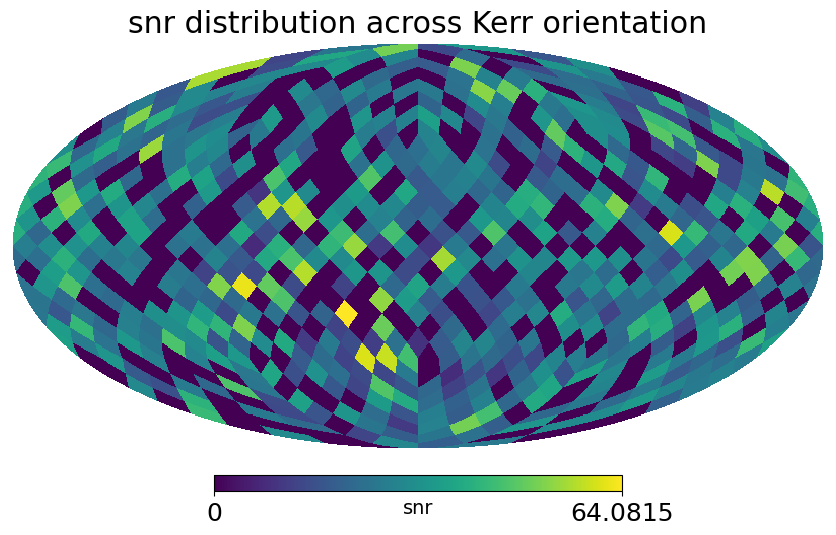

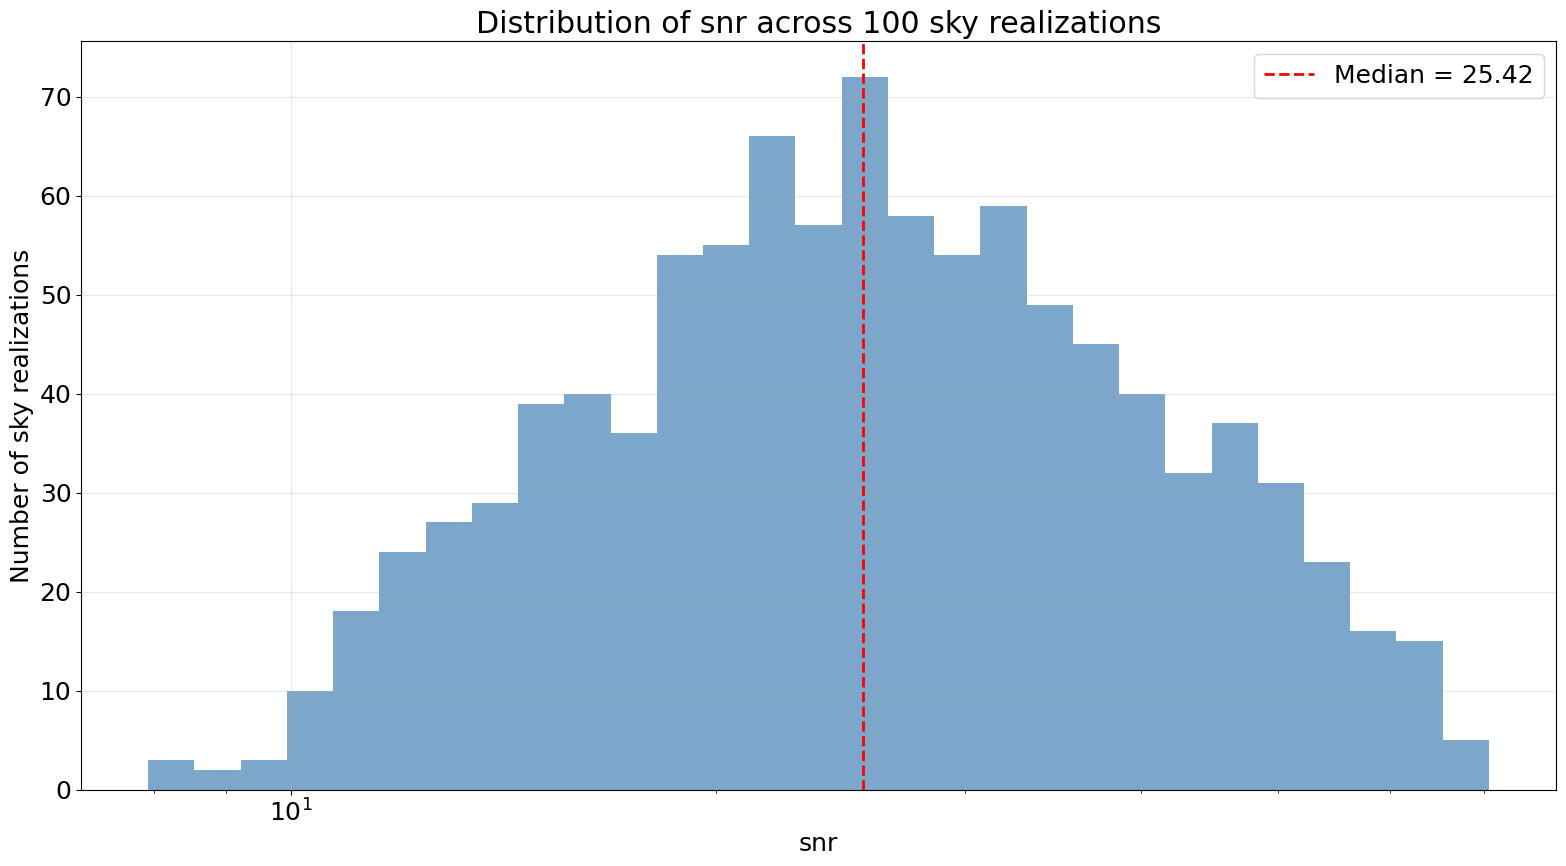

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp

# Visualize sky distribution of measurement precision using HEALPix projection
# This shows how parameter estimation quality varies with source sky location

# Extract angular coordinates from Fisher matrix parameters for source_id=0, eccentric orbit
param_names = inference_metadata[(0, 'eccentric')]['param_names']

# Kerr spin angular momentum direction (θₖ, φₖ)
phi_K = inference_metadata[(0, 'eccentric')]['fish_params'][:, param_names.index('phiK')]
theta_K = inference_metadata[(0, 'eccentric')]['fish_params'][:, param_names.index('qK')]

# Source sky position (θₛ, φₛ)
phi_S = inference_metadata[(0, 'eccentric')]['fish_params'][:, param_names.index('phiS')]
theta_S = inference_metadata[(0, 'eccentric')]['fish_params'][:, param_names.index('qS')]

# Select metric to visualize (e.g., SNR, distance precision, mass precision)
metric_mollview = 'snr'
plot_on_sky = inference_precision_data[(0, 'eccentric')][metric_mollview]

# Create HEALPix sky map (nside=8 gives 768 pixels on the sphere)
plt.figure(figsize=(12, 6))
nside = 8
npix = hp.nside2npix(nside)
sky_map = np.zeros(npix)

# Map each source realization to a HEALPix pixel based on Kerr spin orientation
pixels = hp.ang2pix(nside, theta_K, phi_K)

# Accumulate values in each pixel and compute average
for i, pix in enumerate(pixels):
    sky_map[pix] += plot_on_sky[i]

counts = np.bincount(pixels, minlength=npix)
counts[counts == 0] = 1  # Avoid division by zero
sky_map = sky_map / counts  # Average value per pixel

# Plot Mollweide projection of the sky map
hp.mollview(sky_map, title=f'{metric_mollview} distribution across Kerr orientation', 
            cmap="viridis", unit=metric_mollview)
plt.tight_layout()
# plt.savefig(f'mollview_{metric_mollview}.png', dpi=300, bbox_inches='tight')
plt.show()

# Histogram of the metric distribution across all sky realizations
plt.figure()
bins = np.logspace(np.log10(np.min(plot_on_sky)), np.log10(np.max(plot_on_sky)), 30)
plt.hist(plot_on_sky, bins=bins, histtype='stepfilled', alpha=0.7, color='steelblue')
plt.axvline(np.median(plot_on_sky), color='r', linestyle='dashed', linewidth=2, 
            label=f'Median = {np.median(plot_on_sky):.2f}')
plt.xlabel(metric_mollview)
plt.ylabel("Number of sky realizations")
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'Distribution of {metric_mollview} across 100 sky realizations')
plt.tight_layout()
# plt.savefig(f'histogram_{metric_mollview}.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Select a specific source for detailed sky location analysis
key_source = (20, 'circular')

# Extract angular coordinates for this source
param_names = inference_metadata[key_source]['param_names']

# Kerr spin angular momentum direction
phi_K = inference_metadata[key_source]['fish_params'][:, param_names.index('phiK')]
theta_K = inference_metadata[key_source]['fish_params'][:, param_names.index('qK')]

# Source sky position  
phi_S = inference_metadata[key_source]['fish_params'][:, param_names.index('phiS')]
theta_S = inference_metadata[key_source]['fish_params'][:, param_names.index('qS')]

# Uncomment to visualize normalized coordinates:
# plt.plot(theta_S/np.pi, phi_S/(2*np.pi), '.')
# plt.xlabel('θ / π')
# plt.ylabel('φ / 2π')

/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_2360/2418661253.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

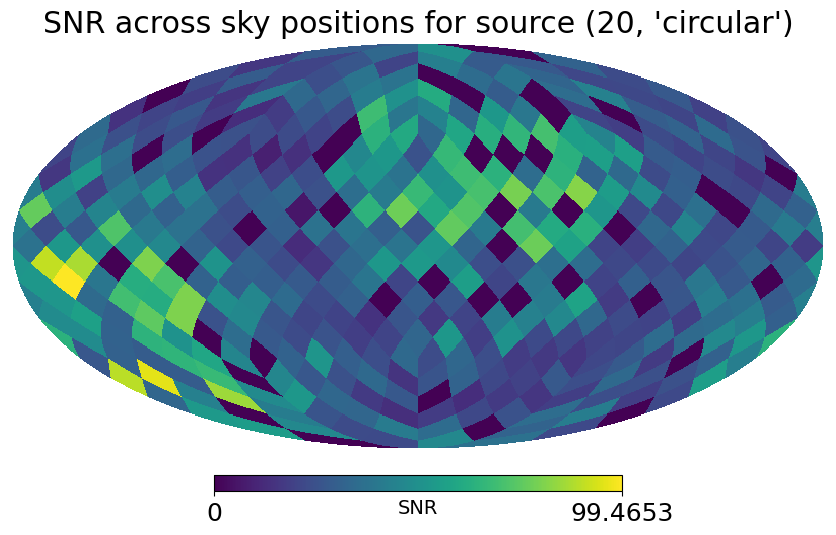

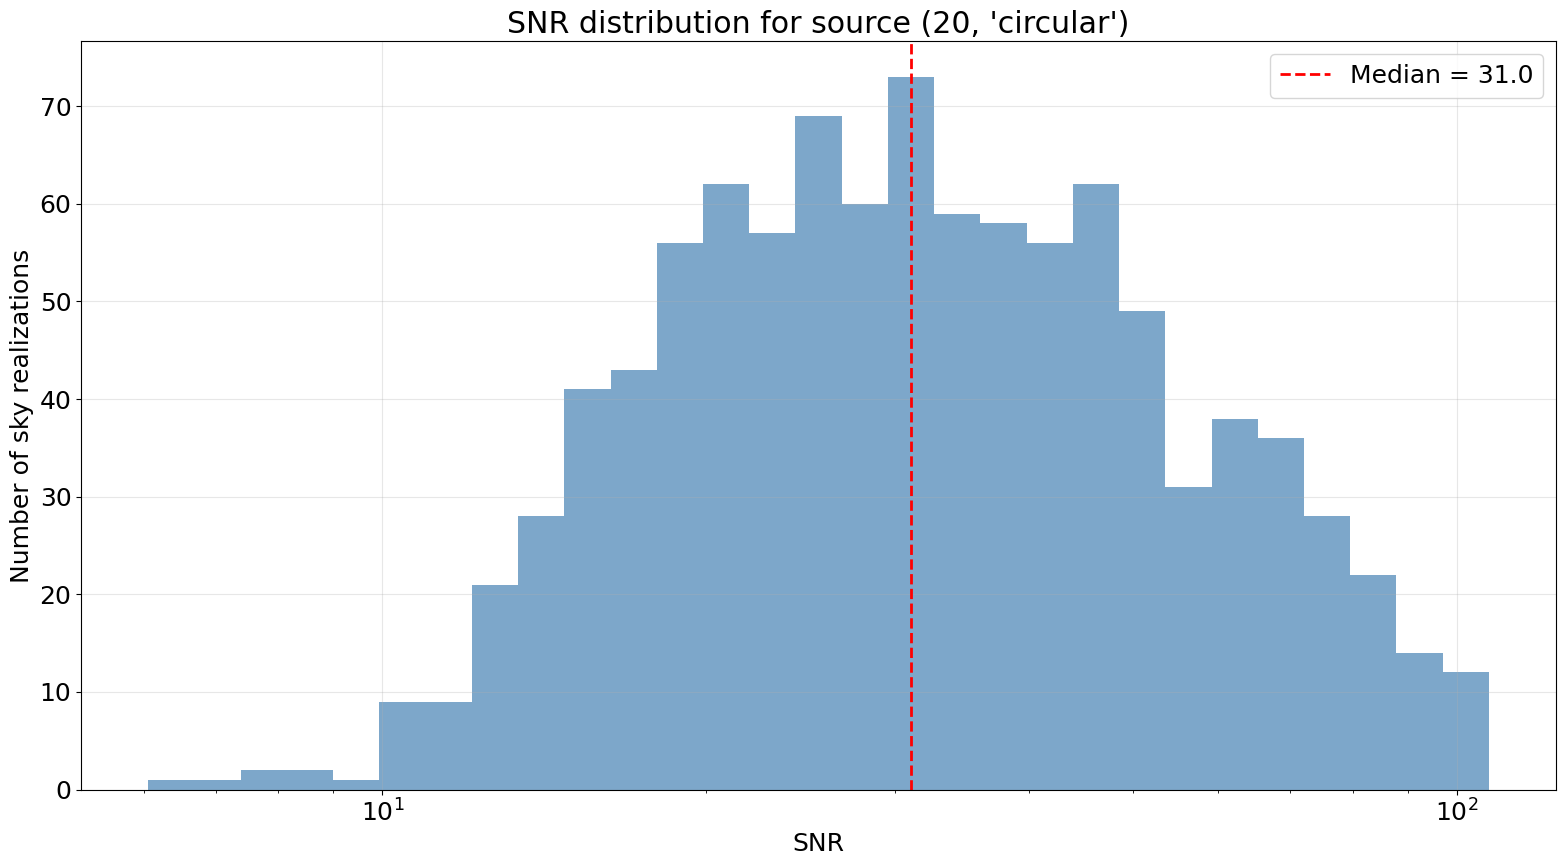

In [21]:
# Visualize SNR (or other metric) distribution across the sky for the selected source
# This uses the source sky position (θₛ, φₛ) rather than Kerr orientation

# Select metric to plot (can also use: 'relative_precision_dist', etc.)
plot_on_sky = inference_metadata[key_source]['snr']
# plot_on_sky = inference_precision_data[key_source]['relative_precision_dist']

# Create HEALPix sky map
plt.figure(figsize=(12, 6))
nside = 6  # Lower resolution for this example
npix = hp.nside2npix(nside)
sky_map = np.zeros(npix)

# Map to pixels based on source sky location (θₛ, φₛ)
pixels = hp.ang2pix(nside, theta_S, phi_S)

# Accumulate and average values in each pixel
for i, pix in enumerate(pixels):
    sky_map[pix] += plot_on_sky[i]

counts = np.bincount(pixels, minlength=npix)
counts[counts == 0] = 1
sky_map = sky_map / counts

# Mollweide projection of sky distribution
hp.mollview(sky_map, title=f"SNR across sky positions for source {key_source}", 
            cmap="viridis", unit="SNR")
plt.tight_layout()
plt.show()

# Histogram of SNR values across sky realizations
plt.figure()
bins = np.logspace(np.log10(np.min(plot_on_sky)), np.log10(np.max(plot_on_sky)), 30)
plt.hist(plot_on_sky, bins=bins, histtype='stepfilled', alpha=0.7, color='steelblue')
plt.axvline(np.median(plot_on_sky), color='r', linestyle='dashed', linewidth=2, 
            label=f'Median = {np.median(plot_on_sky):.1f}')
plt.xlabel("SNR")
plt.ylabel("Number of sky realizations")
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f'SNR distribution for source {key_source}')
plt.tight_layout()
plt.show()

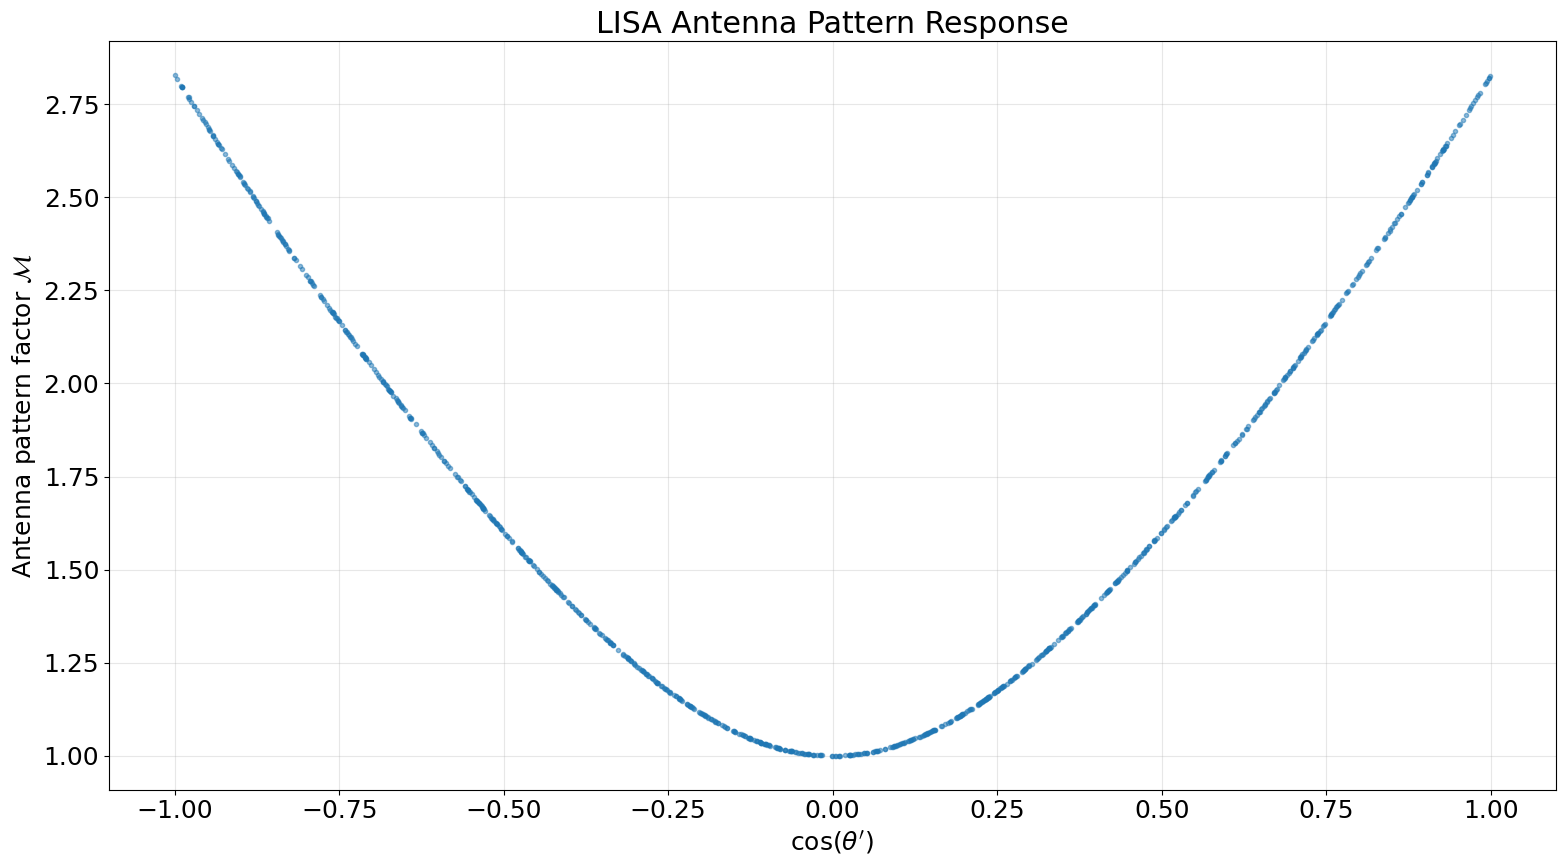

/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_2360/3350276174.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

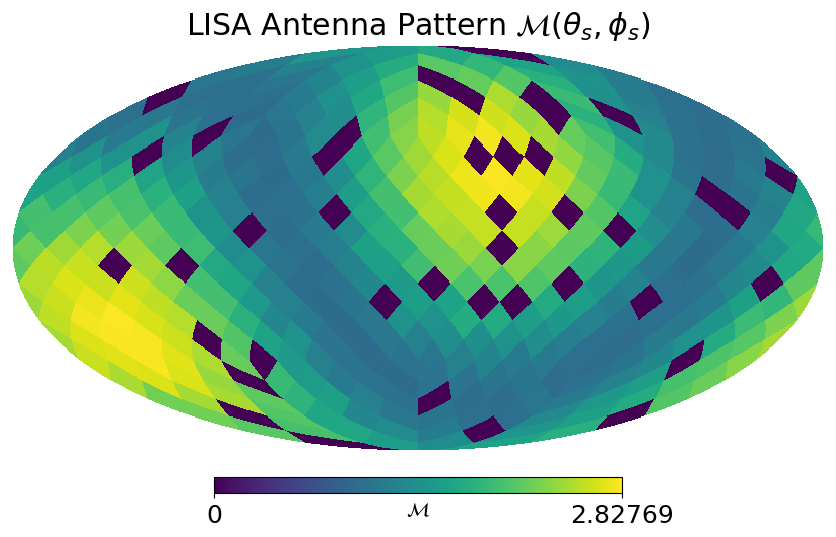

In [22]:
# LISA antenna pattern response function
# Based on Cornish & Rubbo 2003 (https://arxiv.org/pdf/0710.5250)
# The SNR depends on sky location through the antenna pattern function ℳ(θₛ, φₛ)

# Assume LISA arm at t₀ = 0.4 years into mission
t0 = 0.4

# Compute antenna pattern projection (simplified)
# cos(θ') = 1/2 cos(θₛ) - √3/2 sin(θₛ) cos(2πt₀ - φₛ)
cos_theta = 0.5 * np.cos(theta_S) - np.sqrt(3)/2 * np.sin(theta_S) * np.cos(2*np.pi*t0 - phi_S)

# Antenna pattern function: ℳ = √(1 + 6cos²(θ') + cos⁴(θ'))
M = np.sqrt(1 + 6 * cos_theta**2 + cos_theta**4)

# Plot antenna pattern response vs angle
plt.figure()
plt.plot(cos_theta, M, '.', alpha=0.5)
plt.xlabel(r'$\cos(\theta^\prime)$')
plt.ylabel(r'Antenna pattern factor $\mathcal{M}$')
plt.grid(True, alpha=0.3)
plt.title('LISA Antenna Pattern Response')
plt.tight_layout()
plt.show()

# Visualize antenna pattern on the sky using HEALPix
plt.figure(figsize=(12, 6))
nside = 6
npix = hp.nside2npix(nside)
sky_map = np.zeros(npix)
pixels = hp.ang2pix(nside, theta_S, phi_S)

# Average antenna pattern factor in each pixel
for i, pix in enumerate(pixels):
    sky_map[pix] += M[i]

counts = np.bincount(pixels, minlength=npix)
counts[counts == 0] = 1
sky_map = sky_map / counts

hp.mollview(sky_map, title=r"LISA Antenna Pattern $\mathcal{M}(\theta_s, \phi_s)$", 
            cmap="viridis", unit=r"$\mathcal{M}$")
plt.tight_layout()
plt.show()

Source (20, 'circular'): m1=1e+06, m2=100.0


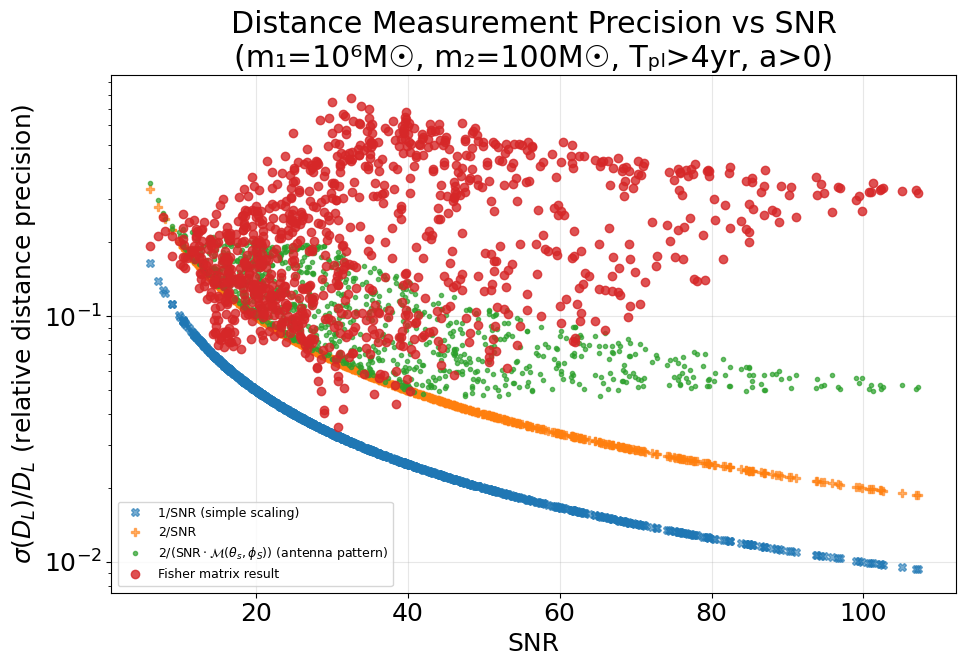

In [23]:
# Explore the relationship between SNR and distance measurement precision
# Theory predicts: σ(D_L)/D_L ∝ 1/SNR, with corrections from antenna pattern

plt.figure(figsize=(10, 7))

# Filter for specific sources: circular orbits, Tpl > 4 years, prograde spin, m1=10⁶M☉, m2=100M☉
for idx, run_type in enumerate(['circular']):
    relative_precisions = []
    for src_key in inference_precision_data:
        # Apply filters
        if (src_key[1] == run_type) and \
           (inference_metadata[src_key]['T'] > 4.0) and \
           (inference_metadata[src_key]['a'] > 0.0) and \
           (np.abs(1 - inference_metadata[src_key]['m1']/1e6) < 1e-6) and \
           (np.abs(1 - inference_metadata[src_key]['m2']/100) < 1e-6):
            
            print(f"Source {src_key}: m1={inference_metadata[src_key]['m1']:.0e}, "
                  f"m2={inference_metadata[src_key]['m2']}")
            
            # Extract sky coordinates for antenna pattern
            param_names = inference_metadata[src_key]['param_names']
            phi_S = inference_metadata[src_key]['fish_params'][:, param_names.index('phiS')]
            theta_S = inference_metadata[src_key]['fish_params'][:, param_names.index('qS')]
            
            # Compute antenna pattern factor
            t0 = 0.4
            cos_theta = 0.5 * np.cos(theta_S) - np.sqrt(3)/2 * np.sin(theta_S) * np.cos(2*np.pi*t0 - phi_S)
            power_factor = np.sqrt(1 + 6 * cos_theta**2 + cos_theta**4)
            
            # Plot theoretical scaling relations
            plt.semilogy(inference_metadata[src_key]['snr'], 
                        1/inference_metadata[src_key]['snr'], 
                        'X', label='1/SNR (simple scaling)', alpha=0.6)
            plt.semilogy(inference_metadata[src_key]['snr'], 
                        2/inference_metadata[src_key]['snr'], 
                        'P', label='2/SNR', alpha=0.6)
            plt.semilogy(inference_metadata[src_key]['snr'], 
                        2*power_factor/(inference_metadata[src_key]['snr']), 
                        '.', label=r'$2/(\mathrm{SNR} \cdot \mathcal{M}(\theta_s,\phi_S))$ (antenna pattern)', 
                        alpha=0.7)
            
            # Plot actual distance precision from Fisher matrix
            plt.semilogy(inference_metadata[src_key]['snr'], 
                        inference_precision_data[src_key]['relative_precision_dist'], 
                        'o', label=f'Fisher matrix result', markersize=6, alpha=0.8)

plt.legend(loc='lower left', fontsize=9)
plt.ylabel(r'$\sigma(D_L)/D_L$ (relative distance precision)')
plt.xlabel('SNR')
plt.title('Distance Measurement Precision vs SNR\n(m₁=10⁶M☉, m₂=100M☉, Tₚₗ>4yr, a>0)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Create interactive widgets for exploring parameter estimation precision

# Dropdown for spin parameter
spin_dropdown_inf = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values_inf],
    description='Spin (a):',
    value=a_values_inf[-1] if a_values_inf else None
)

# Dropdown for mission lifetime
tpl_dropdown_inf = Dropdown(
    options=[(f'Tpl = {t:.2f}', t) for t in tpl_values_inf],
    description='Tpl:',
    value=tpl_values_inf[0] if tpl_values_inf else None
)

# Dropdown to filter by secondary mass
m2_filter_inf = Dropdown(
    options=[('All', 'all')] + [(f'm2 = {m2:.0f}', m2) for m2 in sorted(m2_values_inf)],
    description='Secondary mass:',
    value='all'
)

# Dropdown to filter by run type (circular or eccentric)
run_type_filter_inf = Dropdown(
    options=[('All', 'all'), ('Circular', 'circular'), ('Eccentric', 'eccentric')],
    description='Run type:',
    value='circular'
)

# Dropdown for precision metric selection
options = [
    ('Relative m1 (detector)', 'relative_precision_m1_det'),   # Detector-frame (redshifted) primary mass
    ('Relative m1 (source)', 'relative_precision_m1'),          # Source-frame primary mass
    ('Relative m2 (detector)', 'relative_precision_m2_det'),    # Detector-frame secondary mass
    ('Relative m2 (source)', 'relative_precision_m2'),          # Source-frame secondary mass
    ('Relative distance', 'relative_precision_dist'),           # Luminosity distance
    ('Relative e0', 'relative_precision_e0'),                   # Initial eccentricity (eccentric only)
    ('Absolute a', 'absolute_precision_a'),                     # Absolute spin uncertainty
    ('Relative a', 'relative_precision_a'),                     # Relative spin uncertainty
    ('Absolute OmegaS', 'absolute_precision_OmegaS'),           # Sky localization solid angle
]

precision_metric_inf = Dropdown(
    options=options,
    description='Metric:',
    value='relative_precision_m1'
)

# Output widget for plots
output_inf_plot = Output()

# Mapping from metric keys to LaTeX labels for plot axes
ylabel_map = {
    "relative_precision_m1_det": r"$\sigma_{m_{1,\mathrm{det}}}/m_{1,\mathrm{det}}$",
    "relative_precision_m1": r"$\sigma_{m_{1}}/m_{1}$",
    "relative_precision_m2_det": r"$\sigma_{m_{2,\mathrm{det}}}/m_{2,\mathrm{det}}$",
    "relative_precision_m2": r"$\sigma_{m_{2}}/m_{2}$",
    "relative_precision_dist": r"$\sigma_{d_L}/d_L$",
    "relative_precision_e0": r"$\sigma_{e_0}/e_0$",
    "absolute_precision_a": r"$\sigma_{a}$",
    "relative_precision_a": r"$\sigma_{a}/a$",
    "absolute_precision_OmegaS": r"$\Delta \Omega_S$",
}

In [25]:
def plot_measurement_precision(spin_a, tpl_val, m2_filter, run_type_filter, precision_metric, degradation):
    """
    Plot measurement precision vs m1 for inference analysis.
    Shows effect of detector degradation on parameter estimation precision.
    Handles both 'circular' and 'eccentric' runs with different precision metrics.
    Single panel: Measurement Precision vs m1 with degradation effect
    """
    tolerance = 1e-6
    precision_data = {}
    
    for src_key in sorted(inference_metadata.keys()):
        source_id, run_type = src_key
        
        # Filter by spin and Tpl
        src_a = inference_metadata[src_key]['a']
        src_tpl = inference_metadata[src_key]['T']
        if abs(src_a - spin_a) > tolerance or abs(src_tpl - tpl_val) > tolerance:
            continue
        
        # Filter by run_type if specified
        if run_type_filter != 'all' and run_type != run_type_filter:
            continue
        
        m1 = inference_metadata[src_key]['m1']
        m2 = inference_metadata[src_key]['m2']
        
        # Check if this precision metric exists for this source
        if precision_metric not in inference_precision_data[src_key]:
            continue
        
        # Get precision array and compute median (across 100 realizations)
        precision_array = inference_precision_data[src_key][precision_metric]  # shape (100,)
        precision_orig = estimator(precision_array)
        precision_deg = precision_orig * np.sqrt(degradation)  # Degradation increases uncertainty
        
        # Create a unique key combining m2 and run_type for legend
        data_key = (m2, run_type)
        
        if data_key not in precision_data:
            precision_data[data_key] = {'m1': [], 'precision_orig': [], 'precision_deg': []}
        
        precision_data[data_key]['m1'].append(m1)
        precision_data[data_key]['precision_orig'].append(precision_orig)
        precision_data[data_key]['precision_deg'].append(precision_deg)
    
    # Create figure with single subplot
    with output_inf_plot:
        output_inf_plot.clear_output(wait=True)
        
        if not precision_data:
            print(f"No data found for spin a={spin_a:.2f}, Tpl={tpl_val:.2f} and metric {precision_metric}")
            return
        
        fig, ax1 = plt.subplots(1, 1)
        
        # Get unique m2 values and create colormap
        all_m2_values_inf = sorted(set(m2 for m2, _ in precision_data.keys()))
        colors_inf = plt.cm.tab20(np.linspace(0, 1, len(all_m2_values_inf)))
        m2_to_color_inf = {m2: colors_inf[idx] for idx, m2 in enumerate(all_m2_values_inf)}
        
        # PLOT: Measurement Precision vs m1 with degradation arrows
        for (m2, run_type) in sorted(precision_data.keys()):
            # Filter by m2 if user selected specific value
            if m2_filter != 'all' and m2 != m2_filter:
                continue
            
            m1_vals = np.array(precision_data[(m2, run_type)]['m1'])
            precision_orig = np.array(precision_data[(m2, run_type)]['precision_orig'])
            precision_deg = np.array(precision_data[(m2, run_type)]['precision_deg'])
            
            sort_idx = np.argsort(m1_vals)
            m1_sorted = m1_vals[sort_idx]
            precision_orig_sorted = precision_orig[sort_idx]
            precision_deg_sorted = precision_deg[sort_idx]
            
            color = m2_to_color_inf[m2]
            linestyle = '-'# if run_type == 'circular' else '-.'
            marker = 'o'# if run_type == 'circular' else '^'
            
            # Plot original and degraded measurement precision
            ax1.plot(m1_sorted, precision_orig_sorted, marker=marker, linestyle=linestyle, color=color,
                    markersize=7, linewidth=1.5, label=f'${m2:.0f}$', alpha=0.7)
            ax1.plot(m1_sorted, precision_deg_sorted, 's', linestyle='--', color=color,
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw upward arrows showing degradation (precision gets worse)
            for i in range(len(m1_sorted)):
                ax1.annotate('', xy=(m1_sorted[i], precision_deg_sorted[i]),
                           xytext=(m1_sorted[i], precision_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=color,
                                         lw=1.5, alpha=0.6))
        
        ax1.set_xlabel(r'Primary mass $m_1 [M_\odot]$', )
        # print(ylabel_map[precision_metric])
        # ax1.set_ylabel(f'{precision_metric}')
        ax1.set_ylabel(ylabel_map[precision_metric])
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major')
        
        # First legend for m2 values and run types
        leg1 = ax1.legend(loc='upper center', ncols=4, frameon=True, 
                          title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        # ax1.set_ylim(None, 10)
        
        # Second legend for line styles
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=f'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, loc='lower right', frameon=True)
        ax1.add_artist(leg2)
        
        plt.tight_layout()
        plt.show()


In [26]:
# Display controls and plot
controls_inf = HBox([spin_dropdown_inf, tpl_dropdown_inf, m2_filter_inf, run_type_filter_inf, precision_metric_inf, degradation_slider])
display(controls_inf)
display(output_inf_plot)

# Create interactive plot
_ = interact(plot_measurement_precision, spin_a=spin_dropdown_inf, tpl_val=tpl_dropdown_inf,
             m2_filter=m2_filter_inf, run_type_filter=run_type_filter_inf, 
             precision_metric=precision_metric_inf, degradation=degradation_slider)


Output()

interactive(children=(Dropdown(description='Spin (a):', index=1, options=(('a = -0.99', -0.99), ('a = 0.99', 0…

# Parameter Precision: Mass Ratio Visualization

This section visualizes parameter estimation precision across the EMRI parameter space using scatter plots color-coded by precision values. The plots show how measurement quality varies with:
- Primary mass m₁ (horizontal axis)
- Secondary mass m₂ (vertical axis)
- Precision metric (color scale)

The colorbar shows the range of achievable precision for the selected configuration (spin, mission lifetime, degradation factor).

In [27]:
# Utility function for formatting numbers in scientific notation with significant figures
def format_sigfigs(v, n=2):
    """
    Format value v with n significant figures, avoiding scientific notation when possible.
    Returns LaTeX-formatted string suitable for plot labels.
    
    Example: format_sigfigs(0.0000123, 2) returns '1.2×10⁻⁵'
    """
    if v == 0:
        return '0'
    magnitude = floor(log10(abs(v)))
    # Format mantissa with 1 decimal place
    mantissa = v / (10**magnitude)
    str_out = f'{mantissa:.1f}' + rf'$\times 10^{{{magnitude}}}$'
    return str_out

# Test the formatting function
print(f"Example: {format_sigfigs(0.0000123456, 2)}")

Example: 1.2$\times 10^{-5}$


In [28]:
# Add SNR to ylabel map for consistent plotting
ylabel_map['snr'] = 'SNR'

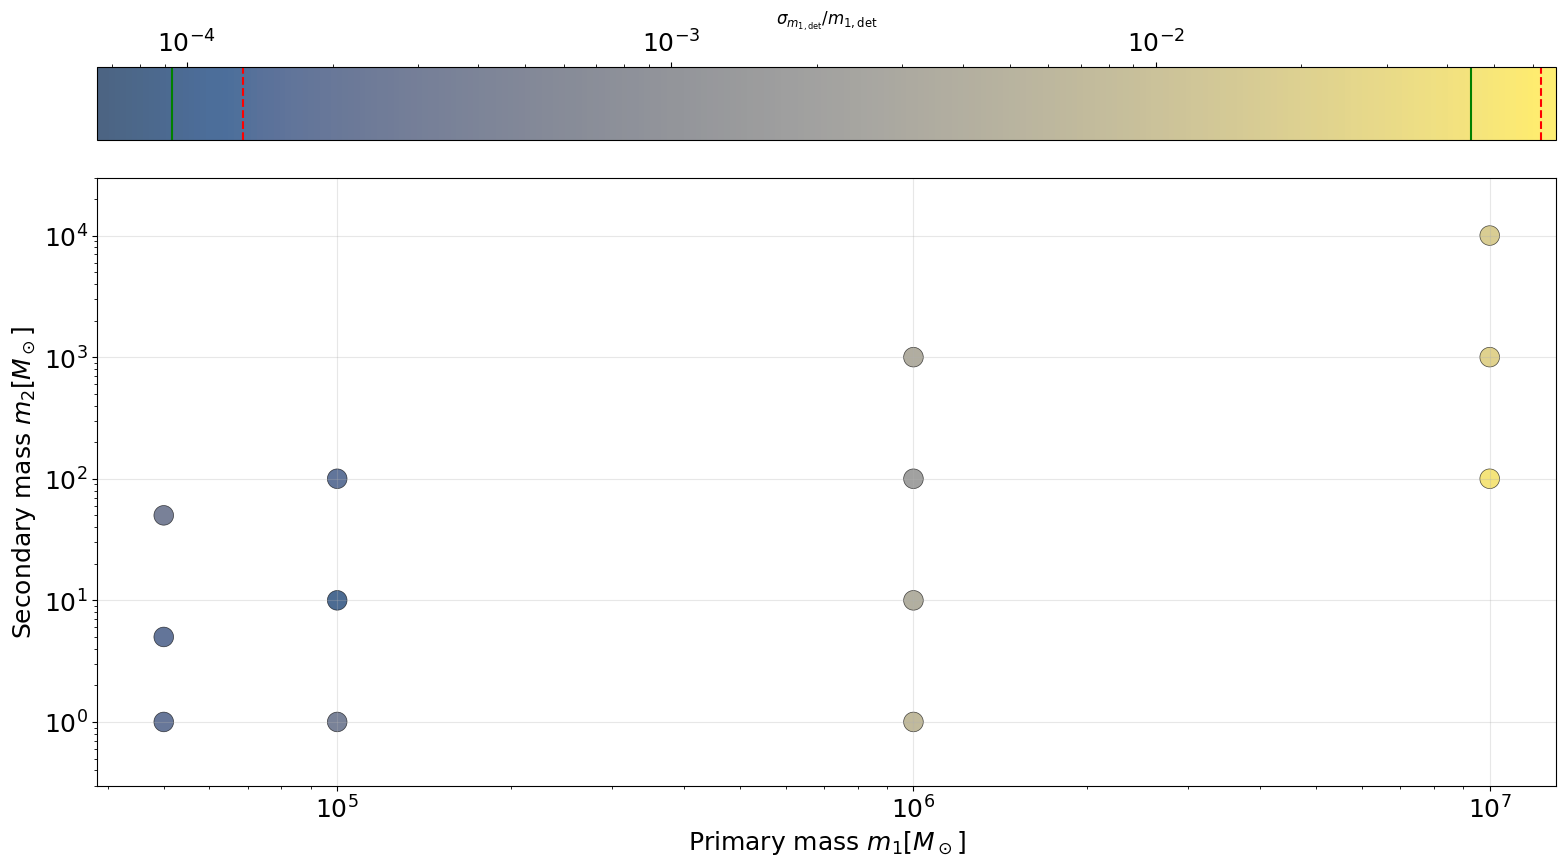

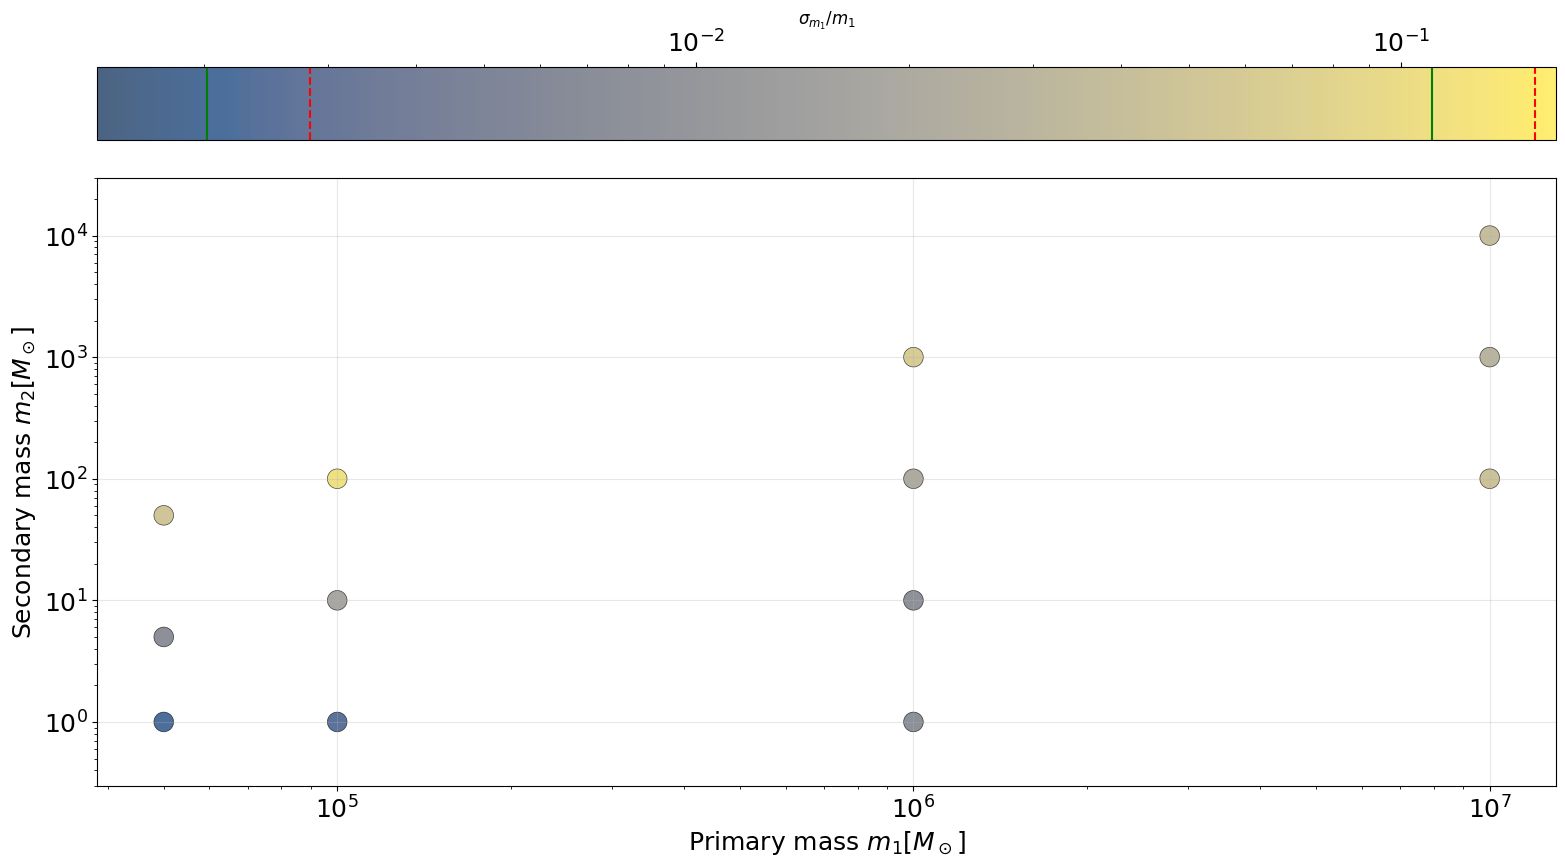

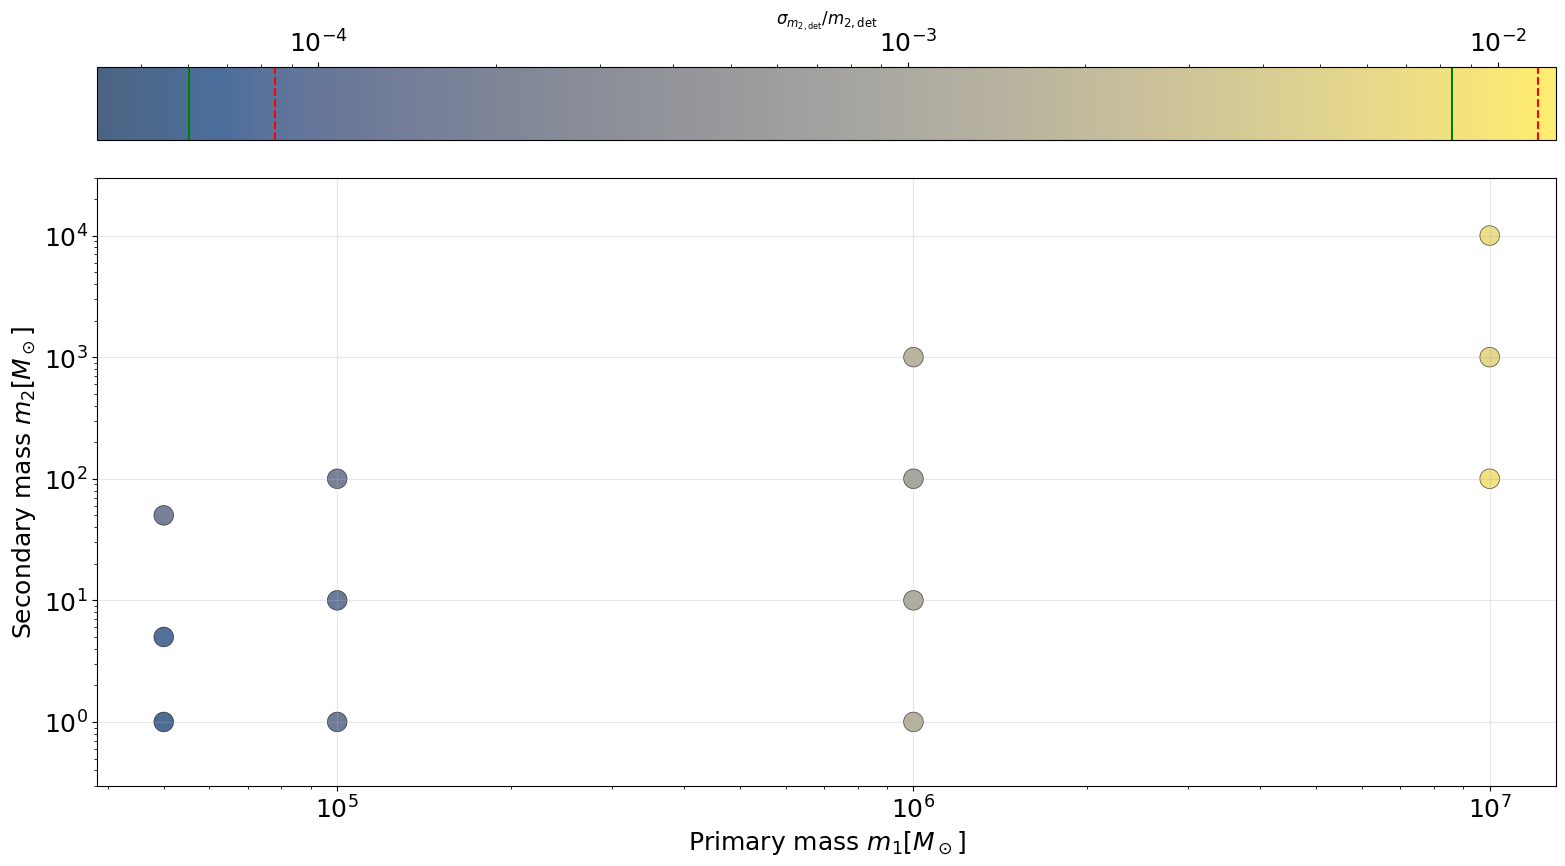

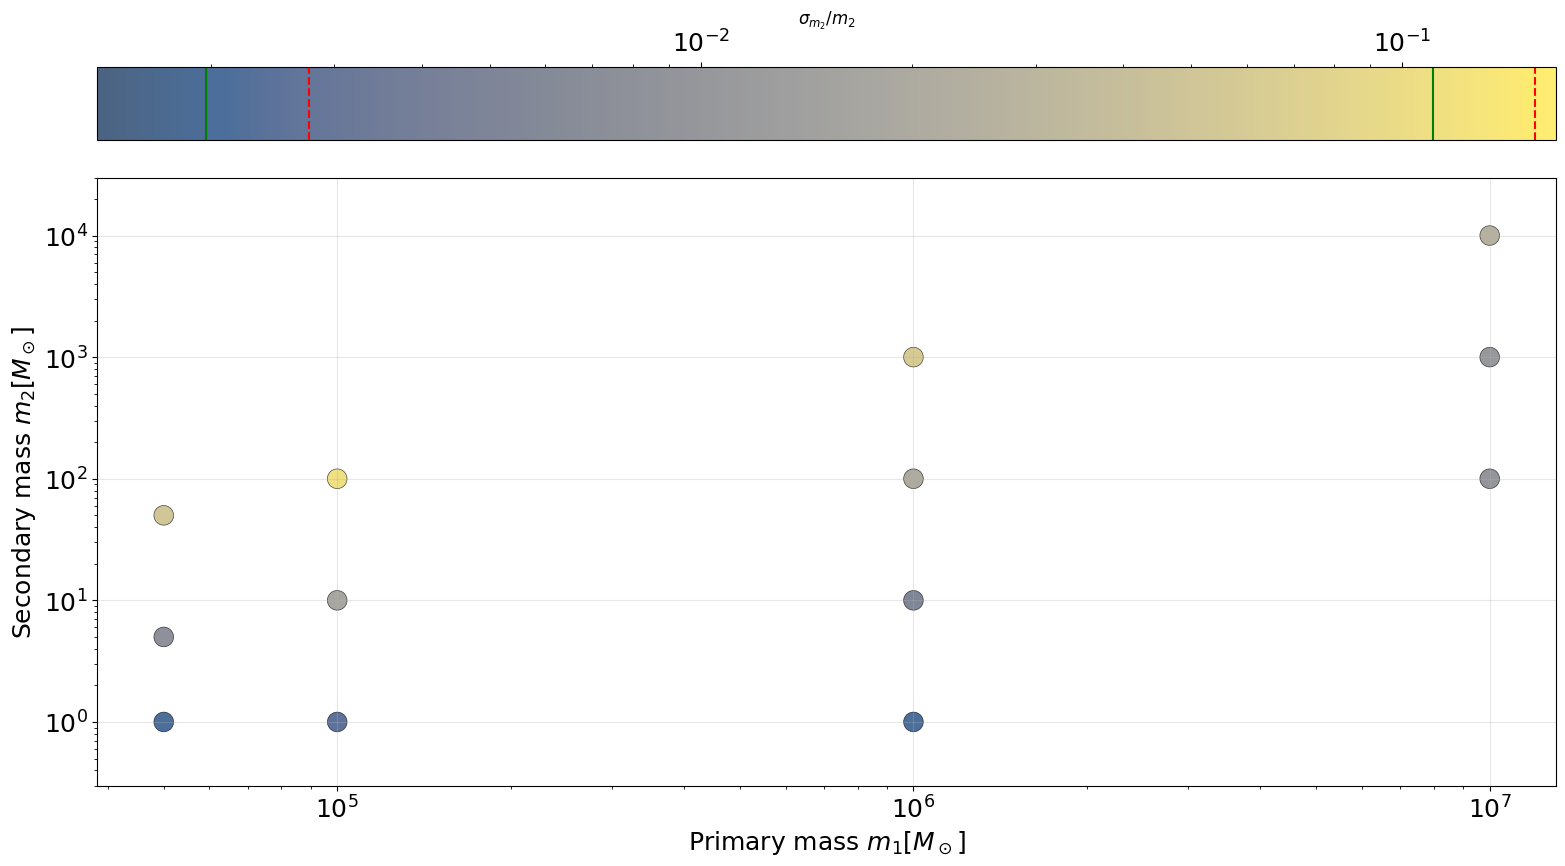

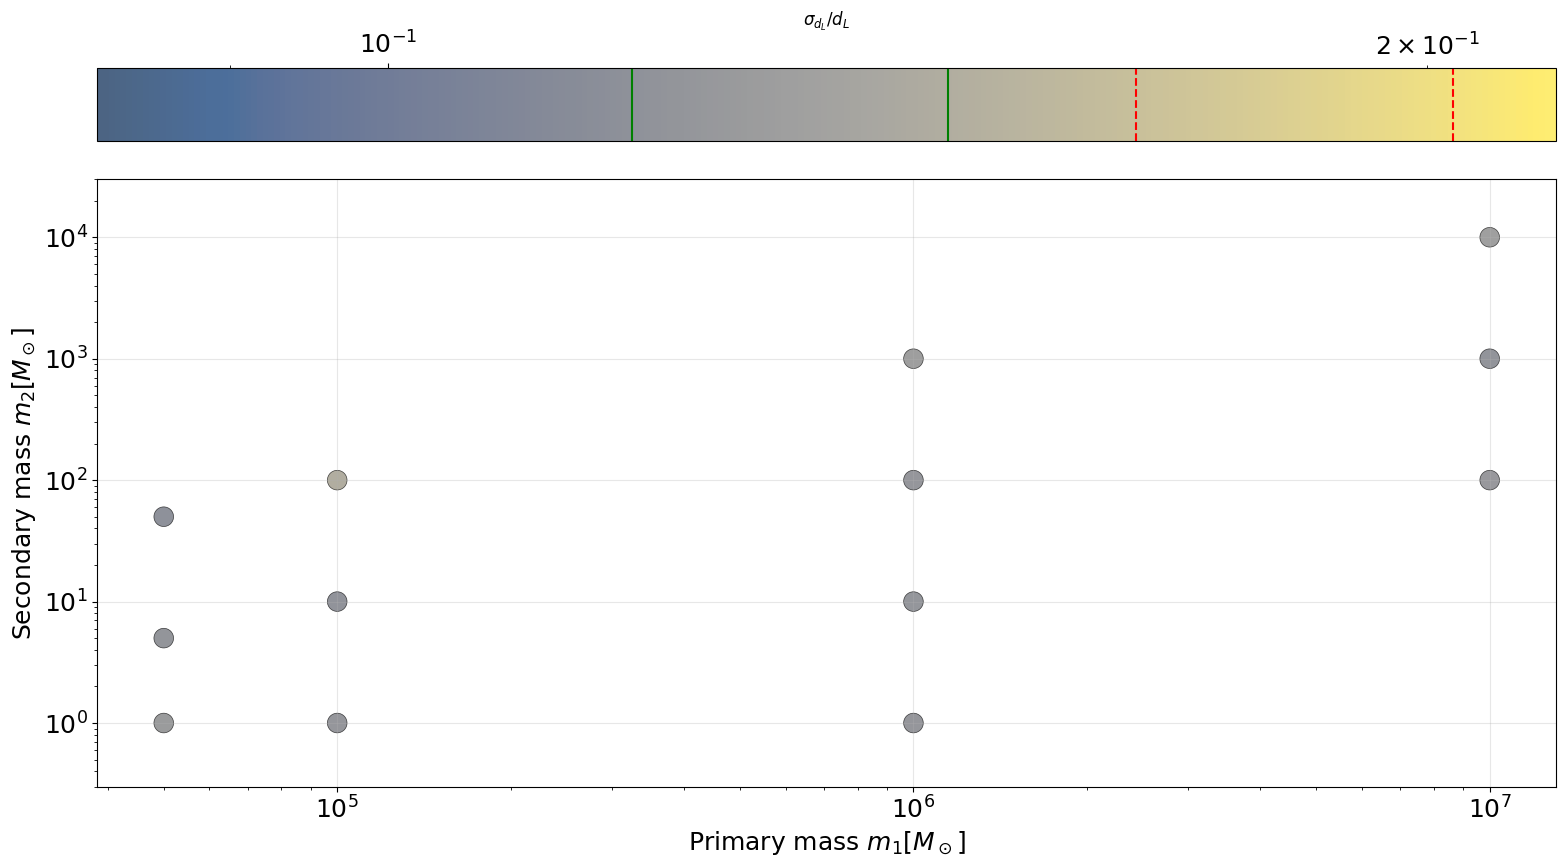

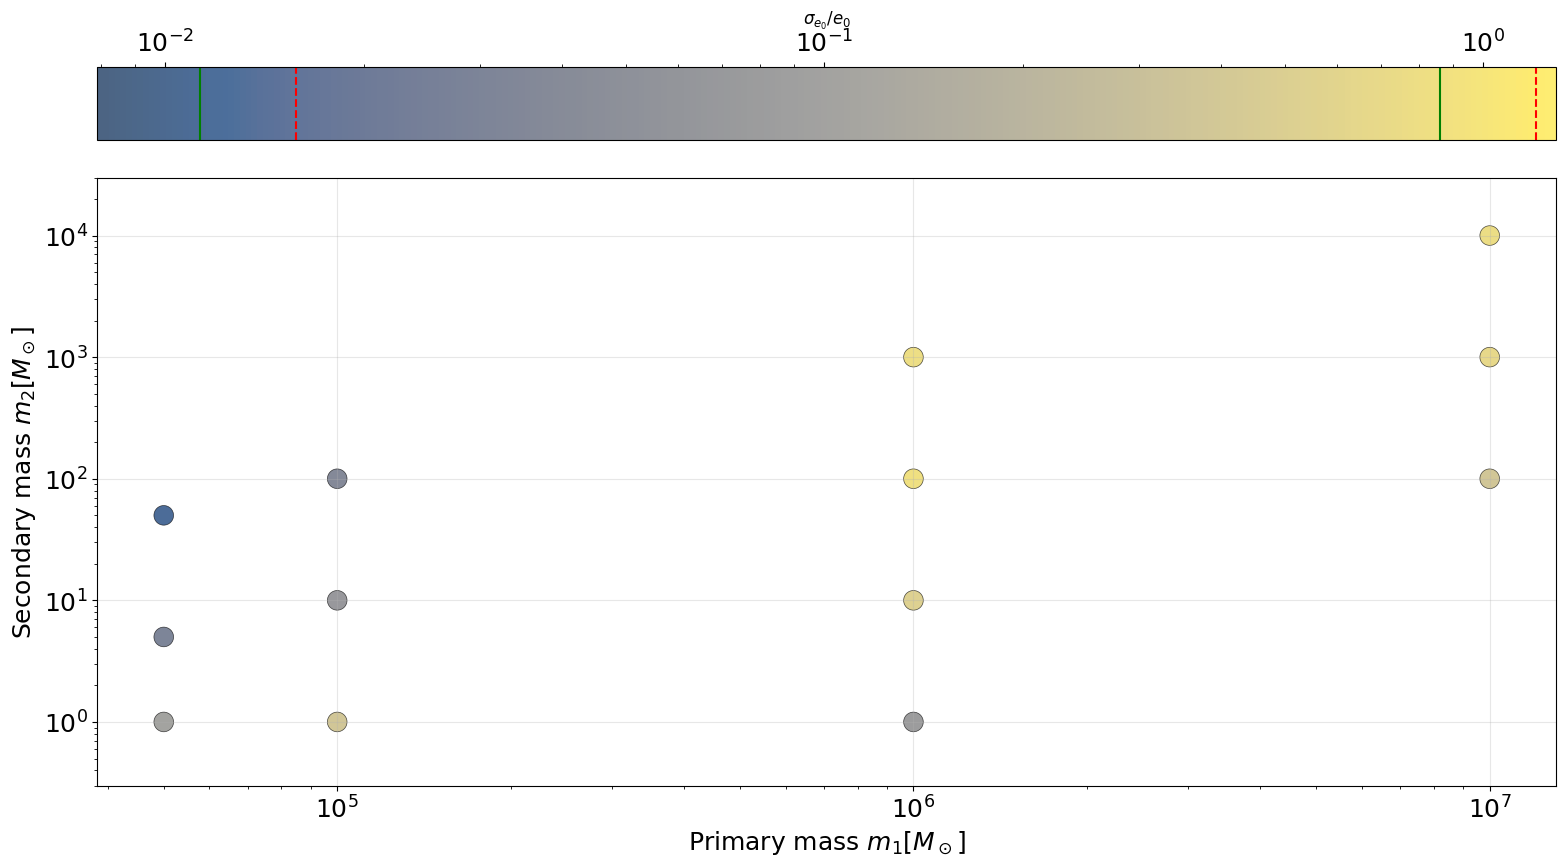

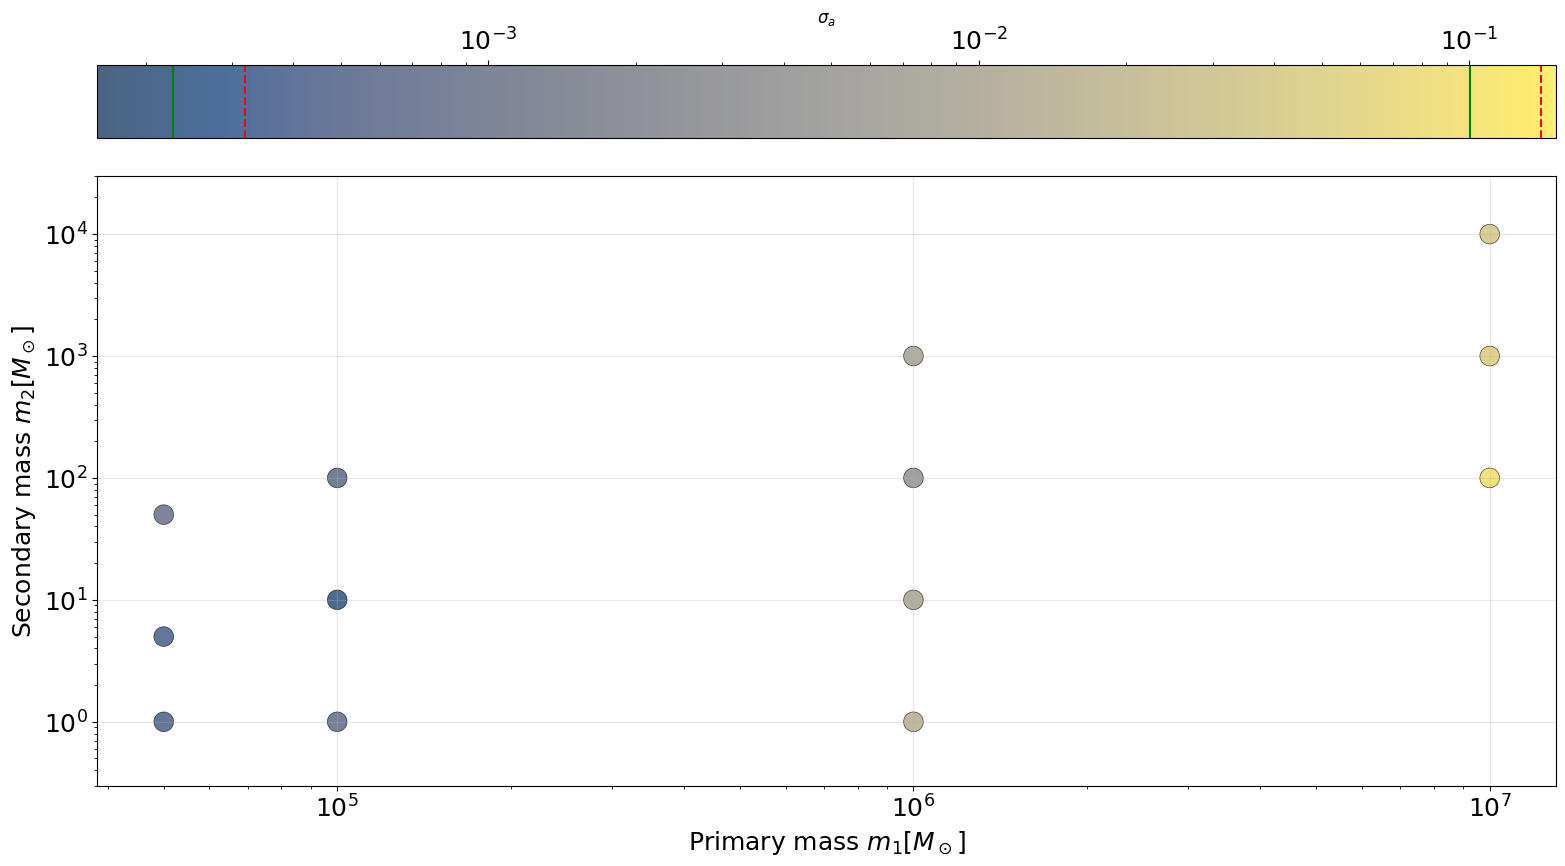

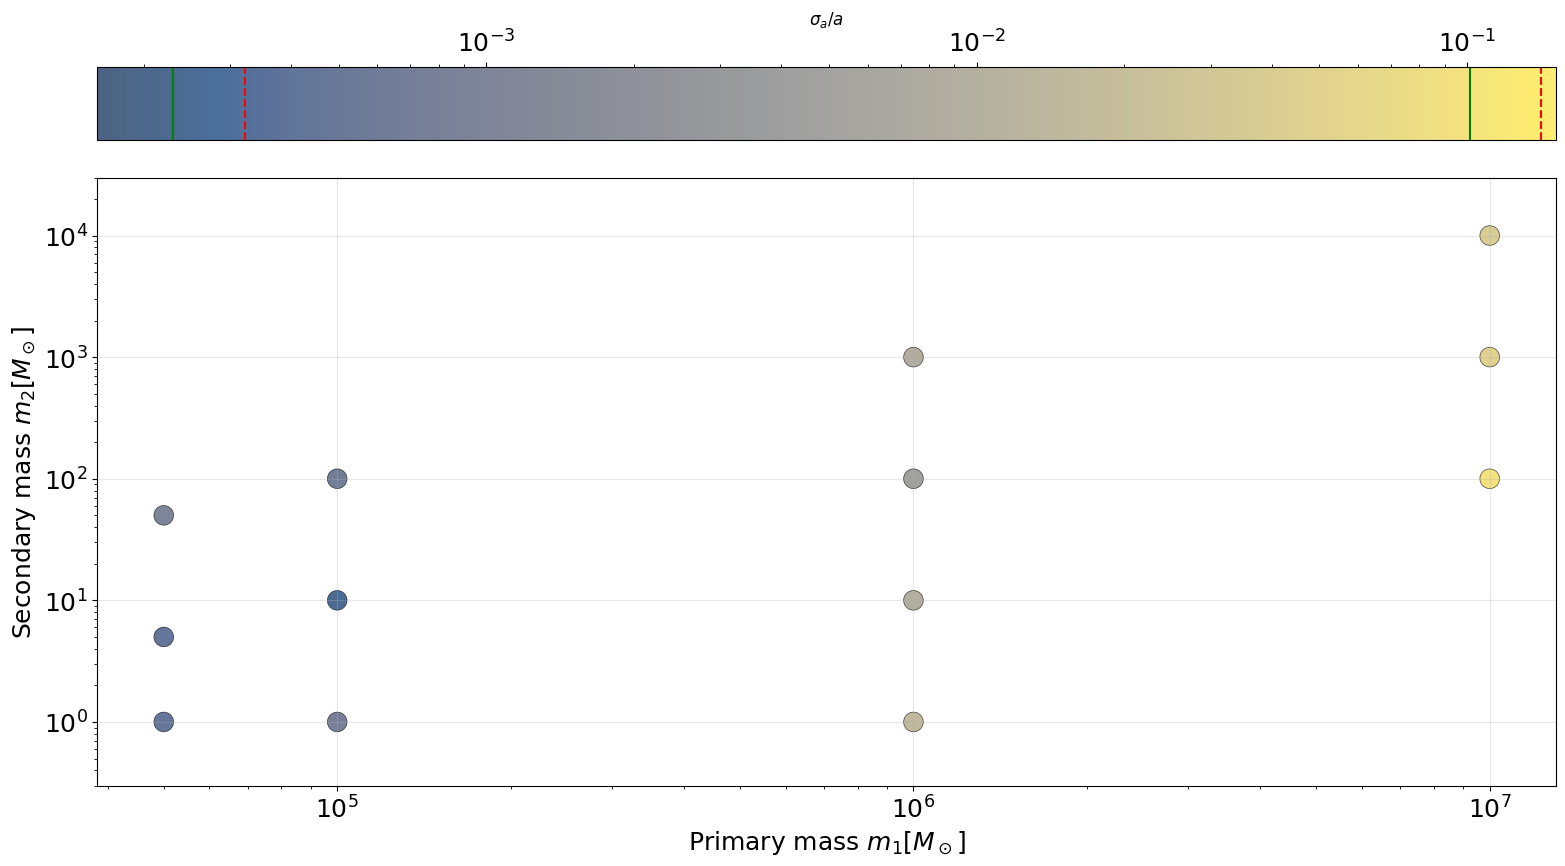

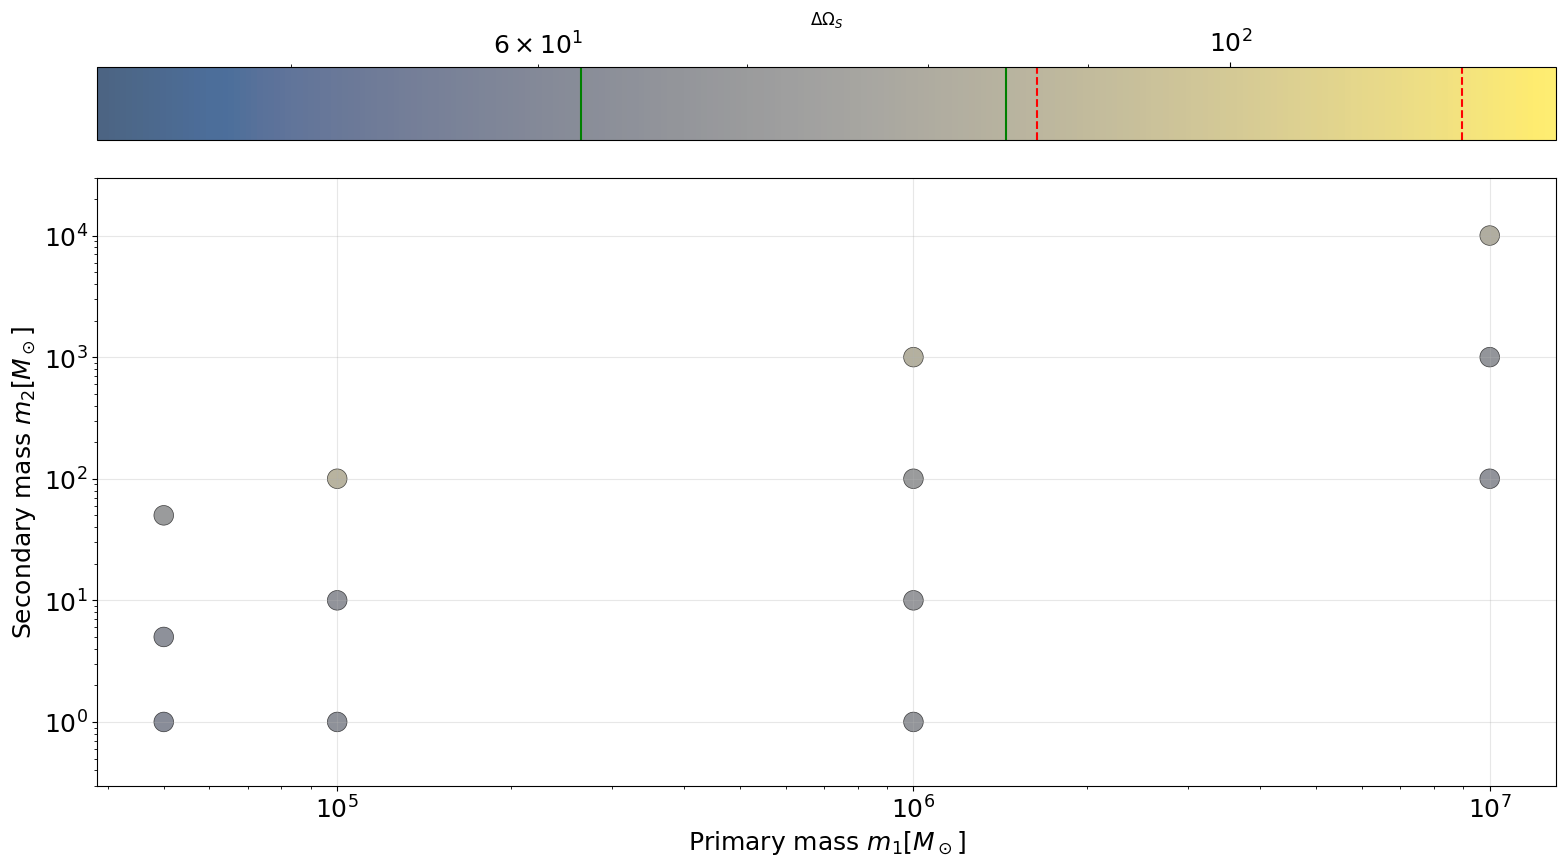

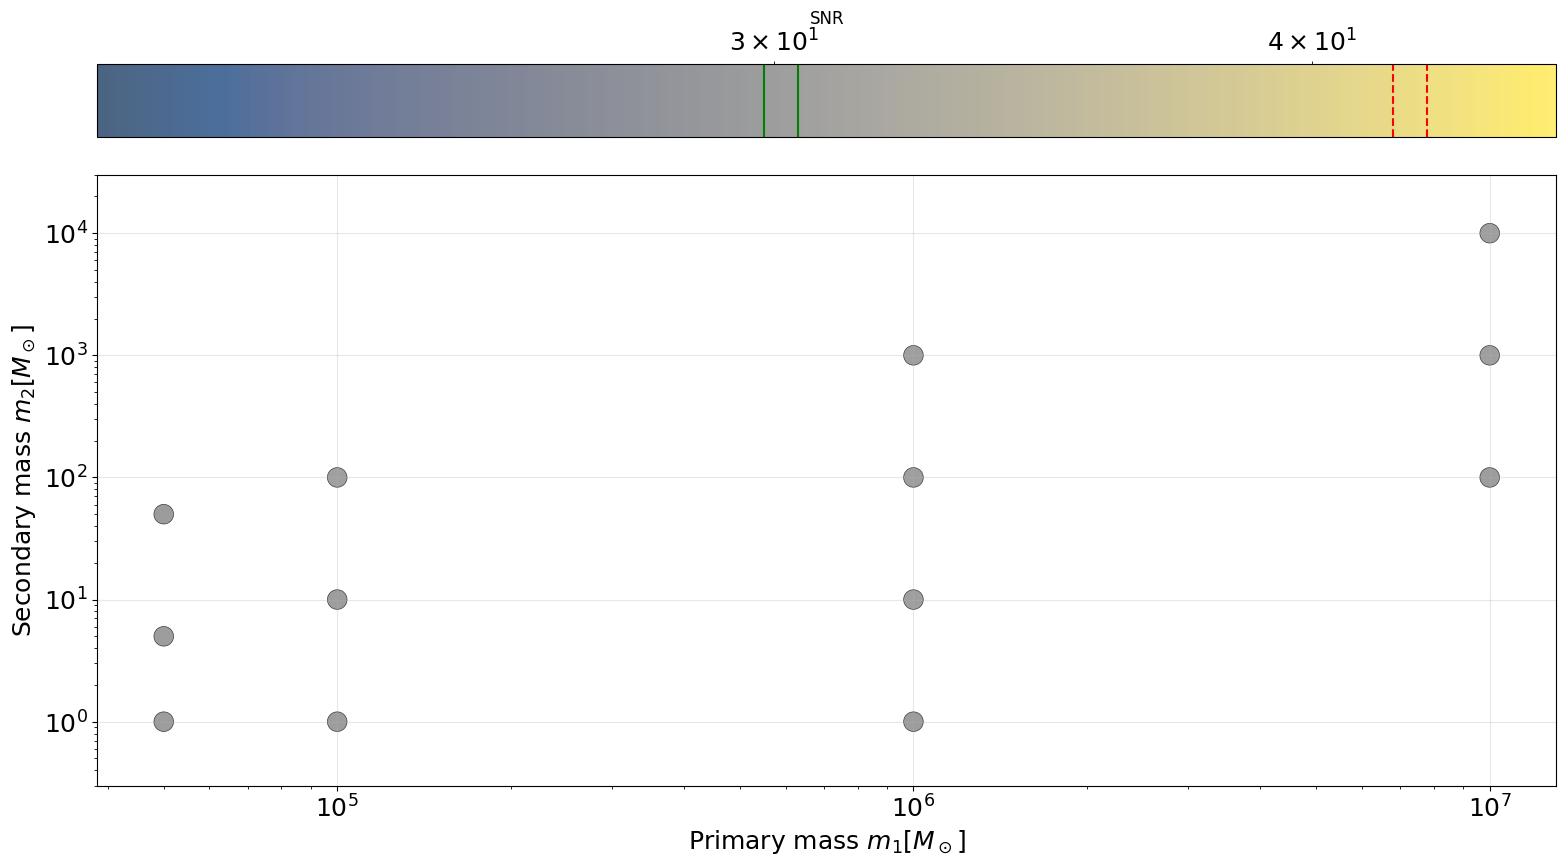

In [29]:
# Scatter plot: m1 vs m2 color-coded by precision metric
# Fixed: spin_a, tpl_val, degradation

spin_a = -0.99  # Prograde
tpl_val = 0.25
for precision_metric in list(ylabel_map.keys()):

    degradation = 1.0
    tolerance = 1e-6
    selected_run_type = 'eccentric'
    scatter_data = {'m1': [], 'm2': [], 'precision': []}

    for src_key in sorted(inference_metadata.keys()):
        source_id, run_type = src_key
        
        # Filter by spin and Tpl
        src_a = inference_metadata[src_key]['a']
        src_tpl = inference_metadata[src_key]['T']
        if abs(src_a - spin_a) > tolerance or abs(src_tpl - tpl_val) > tolerance:
            continue
        
        m1 = inference_metadata[src_key]['m1']
        m2 = inference_metadata[src_key]['m2']
        
        # Check if this precision metric exists for this source
        if precision_metric not in inference_precision_data[src_key]:
            continue
        
        # Get precision array and compute median (across 100 realizations)
        precision_array = inference_precision_data[src_key][precision_metric]
        precision_median = np.median(precision_array)
        precision_deg = precision_median * np.sqrt(degradation)
        
        # Only add circular orbits to avoid duplication
        if run_type == selected_run_type:
            scatter_data['m1'].append(m1)
            scatter_data['m2'].append(m2)
            scatter_data['precision'].append(precision_deg)

    if not scatter_data['m1']:
        print(f"No data found for spin a={spin_a:.2f}, Tpl={tpl_val:.2f} and metric {precision_metric}")
    else:
        fig, ax = plt.subplots()
        
        # Create scatter plot
        m1_arr = np.array(scatter_data['m1'])
        m2_arr = np.array(scatter_data['m2'])
        precision_arr = np.abs(np.array(scatter_data['precision']))
        
        # Create scatter plot with color mapping
        # Use decade-rounded limits for the color scale
        prec_min = float(precision_arr.min())
        prec_max = float(precision_arr.max())
        # vmin_decade = 10 ** np.floor(np.log10(prec_min))
        # vmax_decade = 10 ** np.ceil(np.log10(prec_max))
        vmin_decade = prec_min*0.7
        vmax_decade = prec_max*1.5

        scatter = ax.scatter(m1_arr, m2_arr, c=precision_arr, s=200, cmap='cividis', 
                            alpha=0.7, edgecolors='black', linewidth=0.5, 
                            norm=plt.matplotlib.colors.LogNorm(vmin=vmin_decade, vmax=vmax_decade)
                            # norm=plt.matplotlib.colors.LogNorm(vmin=1e-3, vmax=1.)
                            )
        
        ax.set_xlabel(r'Primary mass $m_1 [M_\odot]$')
        ax.set_ylabel(r'Secondary mass $m_2 [M_\odot]$')
        # ax.set_title(f'Measurement Precision: {precision_metric} (a={spin_a:.2f}, $T_{{pl}}={tpl_val}$, d={degradation})', fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0.3,3e4)
        
        # Add colorbar above the plot with specific ticks for the actual data values
        cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', location='top')
        cbar.set_label(ylabel_map[precision_metric], fontsize=12)
        
        # Set colorbar ticks to the unique precision values from the scatter data
        unique_precision_values = np.sort(np.unique(precision_arr))

        # Add full-width tick lines across the colorbar for each data point value
        cbar_ax = cbar.ax
        for val in [unique_precision_values.min(),unique_precision_values.max()]:
            # Draw a vertical line across the full height of the horizontal colorbar
            cbar_ax.axvline(x=val, color='green', linewidth=1.5, alpha=1.0, linestyle='-')
            
        for val in [unique_precision_values.min(),unique_precision_values.max()]:
            # Draw a vertical line across the full height of the horizontal colorbar
            cbar_ax.axvline(x=val*1.4, color='red', linewidth=1.5, alpha=1.0, linestyle='--')

        # Add arrow between original and degraded values on colorbar
        val_orig = unique_precision_values.min()
        val_deg = val_orig * 1.4
        # cbar_ax.annotate('', 
        #                  xy=(val_deg, 0.5),  # arrow head (degraded value)
        #                  xytext=(val_orig, 0.5),  # arrow tail (original value)
        #                  xycoords=('data', 'axes fraction'),
        #                  textcoords=('data', 'axes fraction'),
        #                  arrowprops=dict(arrowstyle='->', color='goldenrod', lw=2))
        
        # Optionally add arrow for max values too
        val_orig_max = unique_precision_values.max()
        val_deg_max = val_orig_max * 1.4
        # cbar_ax.annotate('', 
        #                  xy=(val_deg_max, 0.5),
        #                  xytext=(val_orig_max, 0.5),
        #                  xycoords=('data', 'axes fraction'),
        #                  textcoords=('data', 'axes fraction'),
        #                  arrowprops=dict(arrowstyle='->', color='goldenrod', lw=2))

        plt.tight_layout()
        plt.show()

# Eccentricity Measurement Precision

Eccentric EMRIs provide richer waveforms that encode additional information about the orbital dynamics. This section analyzes how well LISA can measure the initial orbital eccentricity e₀.

Key insights:
- Precision improves with higher eccentricity (more orbital structure in the signal)
- Mass ratio q = m₂/m₁ affects eccentricity measurability
- Different primary masses m₁ show different scaling behaviors
- Theoretical expectation: σ(e₀)/e₀ ∝ (e₀)⁻ᵅ where α ~ 2-3 at low eccentricities

In [30]:
# Improved formatting function for scientific notation in plot legends
def format_sigfigs(v):
    """
    Format value v in scientific notation for plot legends.
    Simplifies to just '10^n' when mantissa is 1.0.
    
    Examples:
        format_sigfigs(0.00001) returns '10⁻⁵'
        format_sigfigs(0.00003) returns '3×10⁻⁵'
    """
    if v == 0:
        return '0'
    magnitude = floor(log10(abs(v)))
    mantissa = v / (10**magnitude)
    
    # Simplify when mantissa is 1
    if np.isclose(mantissa, 1.0):
        str_out = rf'$10^{{{magnitude}}}$'
    else:
        str_out = f'{mantissa:.0f}' + rf'$\times 10^{{{magnitude}}}$'
    
    return str_out

# Test
print(f"Example: {format_sigfigs(0.00001)}")

Example: $10^{-5}$


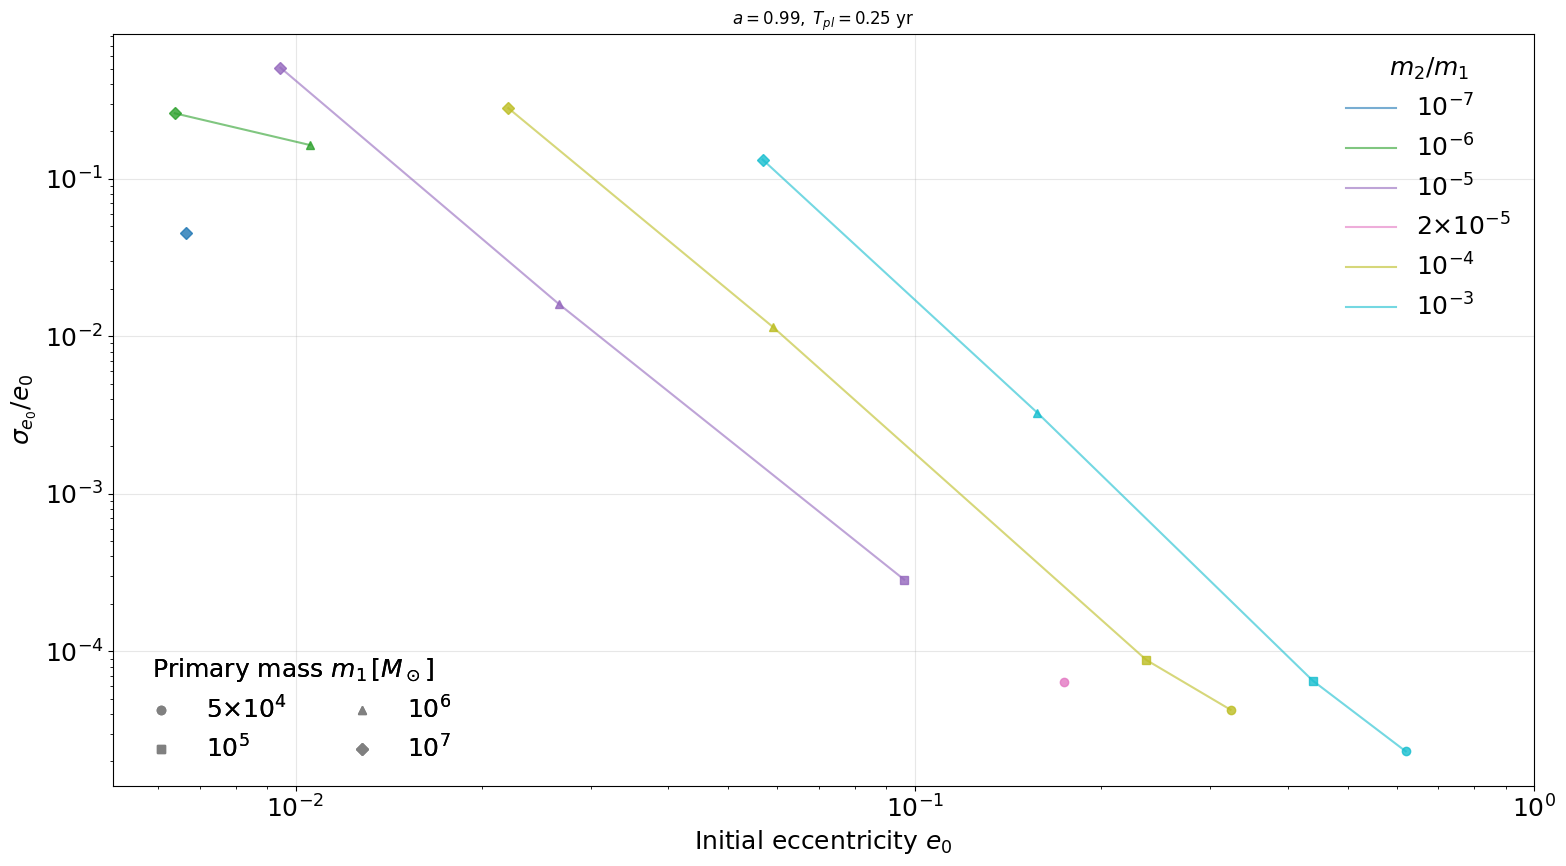

In [31]:
# Plot relative precision on eccentricity vs initial eccentricity e0 for ALL sources
# Fixed configuration: spin, Tpl, run_type
# Color-coded by mass ratio q = m2/m1, different markers for each m1

spin_target = 0.99
tpl_target = 0.25
run_type_target = 'eccentric'
precision_metric = 'relative_precision_e0'

tolerance = 1e-6

# Collect data grouped by (mass ratio q, m1)
data_by_q_m1 = {}

for src_key in sorted(inference_metadata.keys()):
    source_id, run_type = src_key
    if run_type != run_type_target:
        continue

    meta = inference_metadata[src_key]
    if abs(meta['a'] - spin_target) > tolerance:
        continue
    if abs(meta['T'] - tpl_target) > tolerance:
        continue

    if precision_metric not in inference_precision_data[src_key]:
        continue

    m1 = meta['m1']
    m2 = meta['m2']
    e0 = meta['e0']
    q = m2 / m1  # mass ratio
    
    precision_array = np.asarray(inference_precision_data[src_key][precision_metric], dtype=float)
    precision_val = estimator(precision_array)
    p2p5, p97p5 = np.percentile(precision_array, [2.5, 97.5])

    # Round q for grouping (to handle floating point)
    q_key = np.round(q, decimals=10)
    key = (q_key, m1)
    if key not in data_by_q_m1:
        data_by_q_m1[key] = {'e0': [], 'prec': [], 'p2p5': [], 'p97p5': [], 'm1': m1, 'm2': m2, 'q': q_key}
    
    data_by_q_m1[key]['e0'].append(e0)
    data_by_q_m1[key]['prec'].append(precision_val)
    data_by_q_m1[key]['p2p5'].append(p2p5)
    data_by_q_m1[key]['p97p5'].append(p97p5)

if len(data_by_q_m1) == 0:
    print(
        f"No data found for a={spin_target:.2f}, Tpl={tpl_target}, "
        f"run_type={run_type_target}, metric={precision_metric}"
    )
else:
    fig, ax = plt.subplots(1, 1)
    
    # Get unique mass ratios and primary masses
    q_keys = sorted(set(k[0] for k in data_by_q_m1.keys()))
    m1_keys = sorted(set(k[1] for k in data_by_q_m1.keys()))
    
    # Filter out mass ratio 2e-5
    # q_keys = [q for q in q_keys if not np.isclose(q, 2e-5, rtol=1e-2)]
    
    # Create colormap for mass ratios
    colors = plt.cm.tab10(np.linspace(0, 1, len(q_keys)))
    q_to_color = {q: colors[idx] for idx, q in enumerate(q_keys)}
    
    # Define markers for each m1 value
    marker_list = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', 'P']
    m1_to_marker = {m1: marker_list[idx % len(marker_list)] for idx, m1 in enumerate(m1_keys)}
    
    # First, collect all data points grouped by mass ratio q for drawing connecting lines
    data_by_q = {}
    for (q_key, m1), data in data_by_q_m1.items():
        if q_key not in data_by_q:
            data_by_q[q_key] = {'e0': [], 'prec': []}
        data_by_q[q_key]['e0'].extend(data['e0'])
        data_by_q[q_key]['prec'].extend(data['prec'])
    
    # Draw connecting lines for each mass ratio (for legend)
    for q_key in q_keys:
        e0_all = np.asarray(data_by_q[q_key]['e0'])
        prec_all = np.asarray(data_by_q[q_key]['prec'])
        sort_idx = np.argsort(e0_all)
        e0_sorted = e0_all[sort_idx]
        prec_sorted = prec_all[sort_idx]
        
        color = q_to_color[q_key]
        ax.plot(e0_sorted, prec_sorted, '-', color=color, linewidth=1.5, alpha=0.6,
                label=format_sigfigs(q_key))
    
    # Now plot the data points with markers (no label, just markers)
    for (q_key, m1), data in sorted(data_by_q_m1.items()):
        # Skip mass ratio 2e-5
        # if np.isclose(q_key, 2e-5, rtol=1e-2):
        #     continue
        e0_arr = np.asarray(data['e0'])
        prec_arr = np.asarray(data['prec'])
        p2p5_arr = np.asarray(data['p2p5'])
        p97p5_arr = np.asarray(data['p97p5'])

        sort_idx = np.argsort(e0_arr)
        e0_arr = e0_arr[sort_idx]
        prec_arr = prec_arr[sort_idx]
        p2p5_arr = p2p5_arr[sort_idx]
        p97p5_arr = p97p5_arr[sort_idx]

        # Asymmetric errorbars
        yerr_lower = np.maximum(0.0, prec_arr - p2p5_arr)
        yerr_upper = np.maximum(0.0, p97p5_arr - prec_arr)
        yerr = np.vstack([yerr_lower, yerr_upper])

        color = q_to_color[q_key]
        marker = m1_to_marker[m1]
        
        ax.errorbar(
            e0_arr, prec_arr, 
            # yerr=yerr,
            fmt=marker, linestyle='None', color=color, markersize=6,
            elinewidth=1.0, capsize=2, alpha=0.8
        )
    
    ax.set_xlabel(r'Initial eccentricity $e_0$')
    ax.set_ylabel(ylabel_map.get(precision_metric, precision_metric))
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.set_title(
        rf'$a={spin_target:.2f},\; T_{{pl}}={tpl_target}$ yr',
        fontsize=12
    )
    
    # First legend for mass ratio (colors) - uses the lines
    leg1 = ax.legend(frameon=False, loc='upper right', ncol=1, title=r'$m_2/m_1$')
    ax.add_artist(leg1)
    
    # Second legend for primary mass (markers)
    # e0_vec = np.logspace(np.log10(5e-3), np.log10(0.1), 100)
    # ax.plot(e0_vec, e0_vec, 'k--', label=r'$\sigma_{e_0}/e_0 = 1$')
    # ax.text(0.5e-2, 3e-3, r'$\sigma_{e_0}/e_0 = 1$', rotation=20, color='k')
    
    # e0_vec = np.logspace(np.log10(5e-3), np.log10(0.99), 100)
    # e0_vec += 0.1
    # ax.plot(e0_vec, (e0_vec/e0_vec[0])**(-3)/10, 'k:', label=r'$\sigma_{e_0} \propto (e_0)^{-2}$')
    # ax.text(e0_vec[55], (e0_vec[55]/e0_vec[0])**(-3)/60, r'$\sigma_{e_0} \propto (e_0)^{-2}$', rotation=-60, color='k', fontsize=10)
    # add the scaling text
    
    marker_handles = [Line2D([0], [0], marker=m1_to_marker[m1], color='gray', linestyle='None',markersize=6, label=format_sigfigs(m1)) for m1 in m1_keys]
    # marker_handles.append(Line2D([0], [0], color='k', linestyle='--', label=r'$\sigma_{e_0}/e_0 = 1$'))
    leg2 = ax.legend(handles=marker_handles, frameon=False, loc='lower left', ncol=2, title=r'Primary mass $m_1 \, [M_\odot]$', framealpha=0.0)
    ax.add_artist(leg2)
    ax.set_xlim(None, 1)
    plt.tight_layout()
    plt.show()

# Mission Lifetime Impact on Parameter Estimation

This section explores how the LISA mission duration affects parameter estimation precision. Longer observations provide:
- More waveform cycles for better parameter constraints
- Improved mass and spin measurements
- Better sky localization through orbital modulation
- Enhanced distance precision through amplitude calibration

In [32]:

def plot_measurement_precision_vs_tpl(m1_val, spin_a, run_type_filter, precision_metric, degradation):
    """
    Plot measurement precision as a function of Tpl for fixed m1 and all m2 values.
    Similar structure to plot_snr_redshift_vs_tpl but for measurement precision.
    
    Top: Measurement Precision vs Tpl (with degradation effect)
    Bottom: [Optional] Could add another metric or redshift reach
    """
    tolerance = 1e-6
    precision_data_tpl = {}
    
    for src_key in sorted(inference_metadata.keys()):
        source_id, run_type = src_key
        
        # Filter by m1 and spin
        src_a = inference_metadata[src_key]['a']
        src_m1 = inference_metadata[src_key]['m1']
        
        if abs(src_a - spin_a) > tolerance or abs(src_m1 - m1_val) > tolerance:
            continue
        
        # Filter by run_type if specified
        if run_type_filter != 'all' and run_type != run_type_filter:
            continue
        
        tpl = inference_metadata[src_key]['T']
        m2 = inference_metadata[src_key]['m2']
        
        # Check if this precision metric exists for this source
        if precision_metric not in inference_precision_data[src_key]:
            continue
        
        # Get precision array and compute median (across 100 realizations)
        precision_array = inference_precision_data[src_key][precision_metric]  # shape (100,)
        precision_orig = estimator(precision_array)
        precision_deg = precision_orig * np.sqrt(degradation)  # Degradation increases uncertainty
        
        if m2 not in precision_data_tpl:
            precision_data_tpl[m2] = {'tpl': [], 'precision_orig': [], 'precision_deg': []}
        
        precision_data_tpl[m2]['tpl'].append(tpl)
        precision_data_tpl[m2]['precision_orig'].append(precision_orig)
        precision_data_tpl[m2]['precision_deg'].append(precision_deg)
    
    # Create figure with single subplot (measurement precision vs Tpl)
    with output_inf_plot:
        output_inf_plot.clear_output(wait=True)
        
        if not precision_data_tpl:
            print(f"No data found for m1={m1_val:.0e}, a={spin_a:.2f} and metric {precision_metric}")
            return
        
        fig, ax1 = plt.subplots(1, 1)
        
        # Get unique m2 values and create colormap using global m2_values
        all_m2_values_tpl = sorted(set(precision_data_tpl.keys()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(m2_values)))
        m2_to_color_tpl = {m2: colors[m2_values.index(m2)] if m2 in m2_values else colors[0] 
                           for m2 in all_m2_values_tpl}
        
        # PLOT: Measurement Precision vs Tpl with degradation arrows
        for m2 in sorted(precision_data_tpl.keys()):
            tpl_vals = np.array(precision_data_tpl[m2]['tpl'])
            precision_orig = np.array(precision_data_tpl[m2]['precision_orig'])
            precision_deg = np.array(precision_data_tpl[m2]['precision_deg'])
            
            sort_idx = np.argsort(tpl_vals)
            tpl_sorted = tpl_vals[sort_idx]
            precision_orig_sorted = precision_orig[sort_idx]
            precision_deg_sorted = precision_deg[sort_idx]
            
            color = m2_to_color_tpl[m2]
            
            # Plot original and degraded measurement precision
            ax1.plot(tpl_sorted, precision_orig_sorted, 'o-', color=color,
                    markersize=7, linewidth=1.5, label=f'${m2:.0f}$', alpha=0.7)
            ax1.plot(tpl_sorted, precision_deg_sorted, 's--', color=color,
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw upward arrows showing degradation (precision gets worse)
            for i in range(len(tpl_sorted)):
                ax1.annotate('', xy=(tpl_sorted[i], precision_deg_sorted[i]),
                           xytext=(tpl_sorted[i], precision_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=color,
                                         lw=1.5, alpha=0.6))
        
        ax1.set_xlabel(r'Plunge time $T_{{pl}} [\mathrm{yr}]$')
        ax1.set_ylabel(ylabel_map[precision_metric])
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major')
        
        # First legend for m2 values
        leg1 = ax1.legend(loc='upper center', ncols=4, frameon=True, 
                          title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        
        # Second legend for line styles
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, loc='lower right', frameon=True)
        ax1.add_artist(leg2)
        
        plt.tight_layout()
        plt.show()


In [33]:

# Create widgets for measurement precision vs Tpl plot
m1_filtered_inf = [m1 for m1 in sorted(set(inference_metadata[src]['m1'] for src in inference_metadata)) 
                   if m1 in [1e6, 1e7]]

m1_dropdown_precision_tpl = Dropdown(
    options=[(f'm1 = {m1:.0e}', m1) for m1 in m1_filtered_inf],
    description='Primary mass:',
    value=m1_filtered_inf[0] if m1_filtered_inf else None
)

spin_dropdown_precision_tpl = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values_inf],
    description='Spin (a):',
    value=a_values_inf[-1] if a_values_inf else None
)

run_type_filter_precision_tpl = Dropdown(
    options=[('All', 'all'), ('Circular', 'circular'), ('Eccentric', 'eccentric')],
    description='Run type:',
    value='eccentric'
)

precision_metric_precision_tpl = Dropdown(
    options=options,
    description='Metric:',
    value='relative_precision_m1_det'
)

# Display controls and plot
controls_precision_tpl = HBox([m1_dropdown_precision_tpl, spin_dropdown_precision_tpl, 
                               run_type_filter_precision_tpl, precision_metric_precision_tpl, 
                               degradation_slider])
display(controls_precision_tpl)
display(output_inf_plot)

# Create interactive plot
_ = interact(plot_measurement_precision_vs_tpl, m1_val=m1_dropdown_precision_tpl,
             spin_a=spin_dropdown_precision_tpl, run_type_filter=run_type_filter_precision_tpl,
             precision_metric=precision_metric_precision_tpl, degradation=degradation_slider)


Output()

interactive(children=(Dropdown(description='Primary mass:', options=(('m1 = 1e+06', 1000000.0), ('m1 = 1e+07',…

---

## Summary and Key Findings

This notebook provides a comprehensive analysis of how detector degradation affects LISA's ability to detect and characterize EMRIs. The key takeaways are:

### Detection Capabilities
- **SNR Scaling**: Detector degradation by factor *d* reduces SNR by √*d*
- **Redshift Reach**: Degradation reduces the maximum detection distance, limiting the accessible cosmic volume
- **Mass Dependence**: Higher-mass EMRIs maintain detectability over larger distances even with degradation

### Parameter Estimation
- **Distance Precision**: Follows σ(D_L)/D_L ∝ 1/SNR, modified by antenna pattern effects
- **Mass Measurements**: Precision degrades by √*d* under detector degradation
- **Eccentricity**: Better constrained at higher initial eccentricities (more waveform structure)
- **Sky Coverage**: Measurement precision varies significantly with source sky location and Kerr spin orientation

### Mission Lifetime
- Longer missions dramatically improve both detection rates and parameter estimation precision
- Critical for detecting EMRIs with wider initial orbits
- Essential for precision tests of general relativity in the strong-field regime

### Recommendations
The interactive widgets allow exploration of the full parameter space to assess:
- Minimum required sensitivity for specific science goals
- Trade-offs between mission lifetime and source characterization
- Robustness of detections under various degradation scenarios

**Note**: All commented code sections have been preserved for future reference and reproducibility.